# Flight Price Prediction

Statistical learning project

a.y. 2022/2023

**group 13/15:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
import random                                    
from math import isnan
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer


from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from datetime import datetime
import re
import os



**Data Cleaning**

In [29]:

cartella = r'C:\Users\loren\Downloads\progettoSL\scraping'

elenco_file = [file for file in os.listdir(cartella) if file.endswith('.xlsx')]

if not elenco_file:
    print("Nessun file Excel trovato nella cartella.")
else:
    primo_file = os.path.join(cartella, elenco_file[0])
    df_completo = pd.read_excel(primo_file)

    col_name_mapping = {
        'data-ril': 'data_ril',
        'dara_ril': 'data_ril',
        'dati_ril': 'data_ril',
        'aeroproto_partenza': 'aeroporto_partenza',
        'oario_partenza':'orario_partenza',
        'oario_arrivo':'orario_arrivo',
        'orario_arrivp':'orario_arrivo',
        'orario_partenzal':'orario_partenza',
        'orariopartenza':'orario_partenza',
        'orario_partenza ':'orario_partenza',
        'Tariffa': 'tariffa',
        'tariffa ': 'tariffa',
        'tariffa  ': 'tariffa',
        'tariffa   ': 'tariffa',
        'operatore ':'operatore',
        'data_partenza ':'data_partenza',
        'data_ril ':'data_ril'
    }

    for col_old, col_new in col_name_mapping.items():
        if col_old in df_completo.columns:
            df_completo.rename(columns={col_old: col_new}, inplace=True)

    for file in elenco_file[1:]:
        percorso_file = os.path.join(cartella, file)
        df = pd.read_excel(percorso_file)

        for col_old, col_new in col_name_mapping.items():
            if col_old in df.columns:
                df.rename(columns={col_old: col_new}, inplace=True)

        df_completo = pd.concat([df_completo, df], ignore_index=True)

    percorso_output = r'C:\Users\loren\Downloads\progettoSL\dataset.xlsx'

    df_completo.to_excel(percorso_output, index=False)



In [2]:
data = pd.read_excel('dataset.xlsx')

In [3]:
data

,orario_partenza,orario_arrivo,aeroporto_partenza,aeroporto_arrivo,tipo,durata,operatore,prezzo,tariffa,data_partenza,data_ril,distanza
0,6:15,9:25,FCO,JTR,diretto,2h 10m,Vueling,127 €,Economy,lun 24/7,21\6',1273
1,6:15,9:25,FCO,JTR,diretto,2h 10m,Vueling,127 €,Economy,lun 24/7,21\6',1273
2,7:05,23:59,FCO,JTR,1 scalo,15h 54m,Ryanair,76 €,Tariffa Standard,lun 24/7,21\6',1273
3,6:15,9:25,FCO,JTR,diretto,2h 10m,Iberia,268 €,Tariffa di base,lun 24/7,21\6',1273
4,17:05,23:30,FCO,JTR,1 scalo,5h 25m,"Aeroitalia, Volotea",102 €,Economy,lun 24/7,21\6',1273
...,...,...,...,...,...,...,...,...,...,...,...,...
86488,17:35,1:20+1,FCO,KEF,1 scalo,9h 45m,"Vueling, PLAY",442 €,Economy,dom 20/8,18\7',3322
86489,11:25,0:10+1,FCO,KEF,1 scalo,14h 45m,Scandinavian Airlines,437 €,Economy,dom 20/8,18\7',3322
86490,20:50,9:45+1,FCO,KEF,1 scalo,14h 55m,Scandinavian Airlines,437 €,Economy,dom 20/8,18\7',3322
86491,13:25,23:30,FCO,KEF,1 scalo,12h 05m,Lufthansa,498 €,Economy Light,dom 20/8,18\7',3322


In [ ]:
#in order to remove some data from july
pattern = r'[a-z]{3} \d{2}/7'  # Corrisponde a due cifre, seguite da /7

data = data[~data['data_partenza'].str.match(pattern)]

Features Engineering

In [13]:
data = pd.read_excel('dataset.xlsx')

In [14]:
data.dropna(inplace = True)

data = data[~data.index.duplicated(keep='first')]

data = data[~data['orario_arrivo'].str.contains('\+1')]
data = data[~data['operatore'].str.contains('Flixbus')]
data = data[~data['operatore'].str.contains('FlixBus')]
data = data[~data['aeroporto_partenza'].str.contains('DBV')]
data = data[~data['operatore'].str.contains('Treno')]
data = data[~data['operatore'].str.contains('Italotreno')]
data = data[~data['operatore'].str.contains('Trenitalia')]
data = data[~data['tipo'].str.contains('2 scali')]
#data = data[~data['operatore'].str.contains('Aeroitalia')]

In [15]:
def clean_price(value):
    if isinstance(value, (int, float)):
        return value
    try:
        new_price = int(re.sub(r'[^\d]', '', str(value)))
        return new_price
    except:
        return None

data['prezzo'] = data['prezzo'].apply(clean_price)
#data.dropna(subset=['prezzo'], inplace=True)


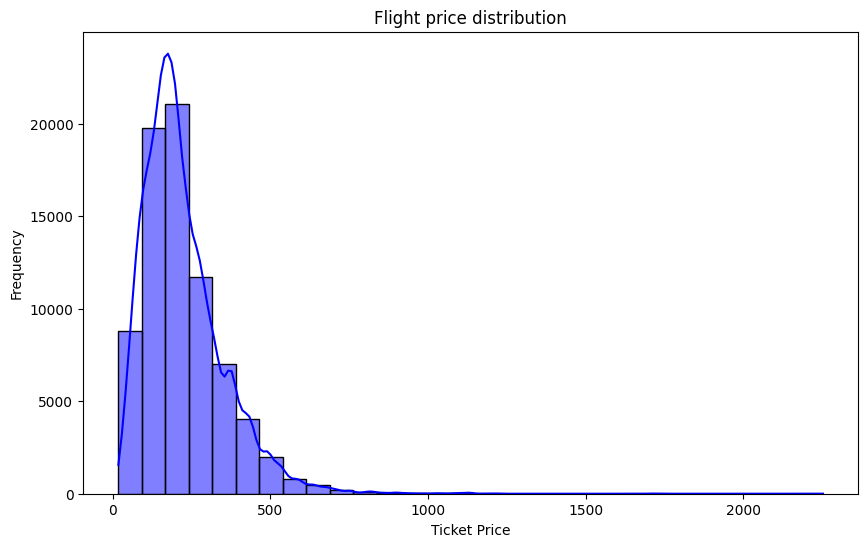

In [16]:
#price data visualization
plt.figure(figsize=(10, 6)) 

sns.histplot(data['prezzo'], bins=30, color='blue', kde=True)

plt.xlabel('Ticket Price')
plt.ylabel('Frequency')
plt.title('Flight price distribution')

plt.show()


In [17]:
def transform_row(row):
    if row['tipo'] == 'diretto':
        row['tipo'] = 0
    elif row['tipo'] == '1 scalo' or row['tipo'] == '1 cambio':
        row['tipo'] = 1
    return row

data = data.apply(transform_row, axis=1)


<Figure size 800x600 with 0 Axes>

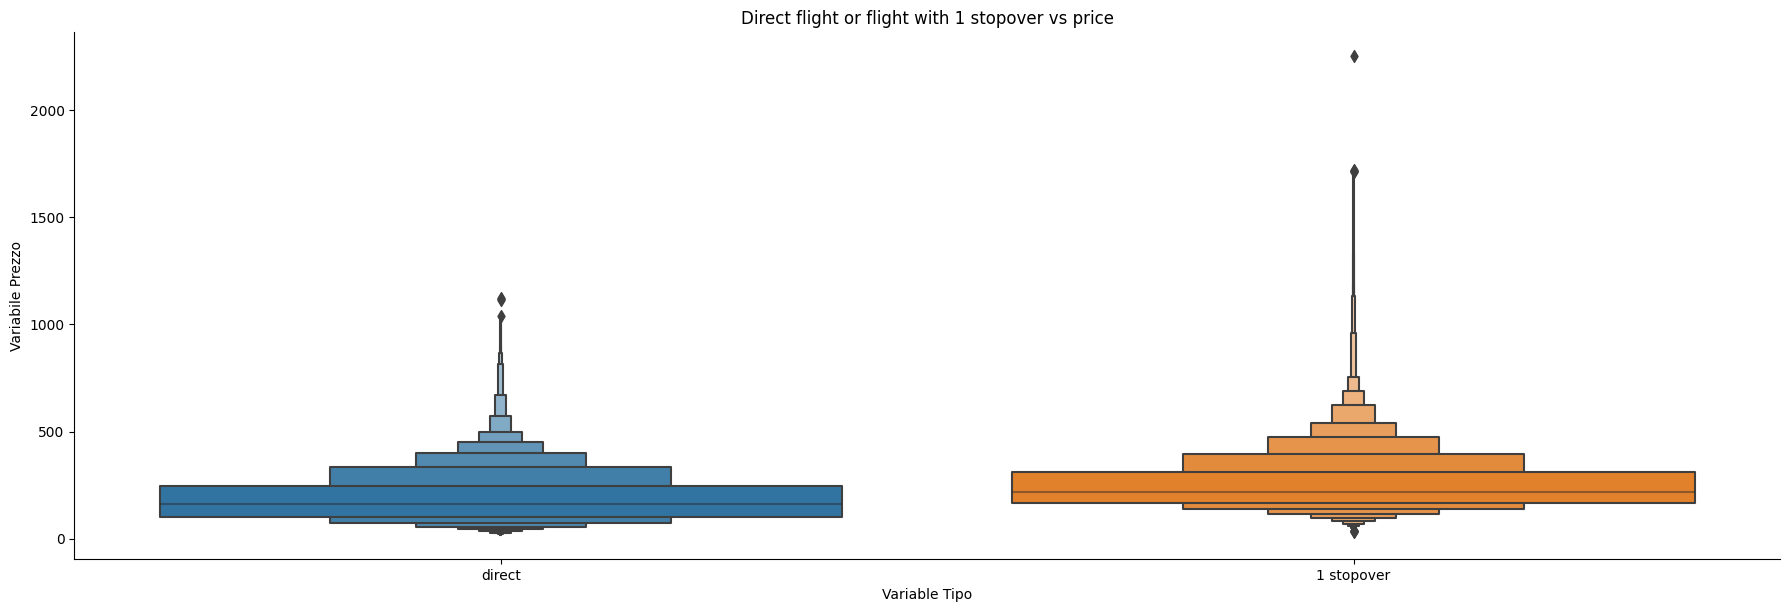

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

#violin plot Tipo-Prezzo
plt.figure(figsize=(8, 6))
sns.catplot(x='tipo', y='prezzo', data = data.sort_values("prezzo", ascending = False), kind="boxen", order= [0,1], height = 6, aspect = 3)
plt.title('Direct flight or flight with 1 stopover vs price')
plt.xticks([0, 1], ['direct','1 stopover'])  
plt.xlabel('Variable Tipo')
plt.ylabel('Variabile Prezzo')
plt.show()

In [19]:
def convert_hours_minutes_to_minutes(duration_str):
    match = re.match(r'(\d+)h (\d+)m', duration_str)
    
    if match:
        hours = int(match.group(1))
        minutes = int(match.group(2))
        total_minutes = hours * 60 + minutes
        return total_minutes
    else:
        return None

for i in data.index:
    duration_str = data.loc[i, 'durata']
    if isinstance(duration_str, str):
        new_duration = convert_hours_minutes_to_minutes(duration_str)
        data.loc[i, 'durata'] = new_duration

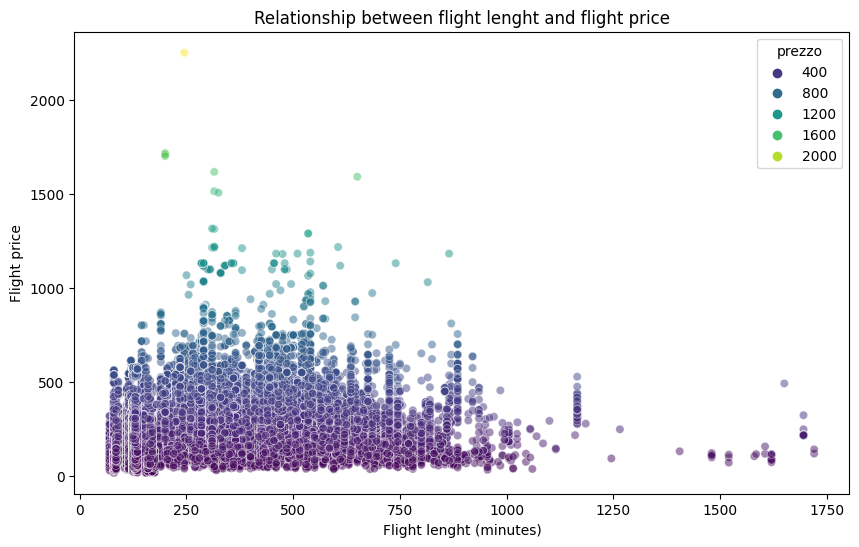

In [20]:
plt.figure(figsize=(10, 6)) 
sns.scatterplot(x=data['durata'], y=data['prezzo'], color='blue', alpha=0.5,  hue=data['prezzo'], palette="viridis")
plt.xlabel('Flight lenght (minutes)')
plt.ylabel('Flight price')
plt.title('Relationship between flight lenght and flight price')
plt.show()

In [21]:
data['tariffa'] = data['tariffa'].replace({'Tariffa Standard': 'Standard', 'Tariffa di base': 'Standard', 'Economy Light': 'Light'})
data['tariffa'] = data['tariffa'].replace({'Economy Saver': 'Economy', 'Economy Flex': 'Economy', 'Economy Standard': 'Economy', 'Economy Classic': 'Economy'})
data['tariffa'] = data['tariffa'].replace({'Business Flessibile': 'Business', 'Business Flex': 'Business', 'Business Light': 'Business', 'Business Optimal': 'Business', 'Business Promozionale': 'Business','Business Saver': 'Business'})
data['tariffa'] = data['tariffa'].replace({'Standard Economy': 'Standard', 'Tariffa flessibile': 'Flex', 'Flessibile': 'Flex', 'Basic Economy':'Basic'})
data['tariffa'] = data['tariffa'].replace({'Classic': 'Standard', 'Discount': 'Economy', 'EcoFly': 'Economy','Saver':'Economy','Smart':'Economy','LowFare':'Economy','Light':'Economy','Basic':'Economy','Optimal':'Economy','Flex':'Economy'})
data['tariffa'] = data['tariffa'].replace({'Saga Premium': 'Business', 'Plus': 'Business', 'Prima classe': 'Business', 'Executive': 'Business'})

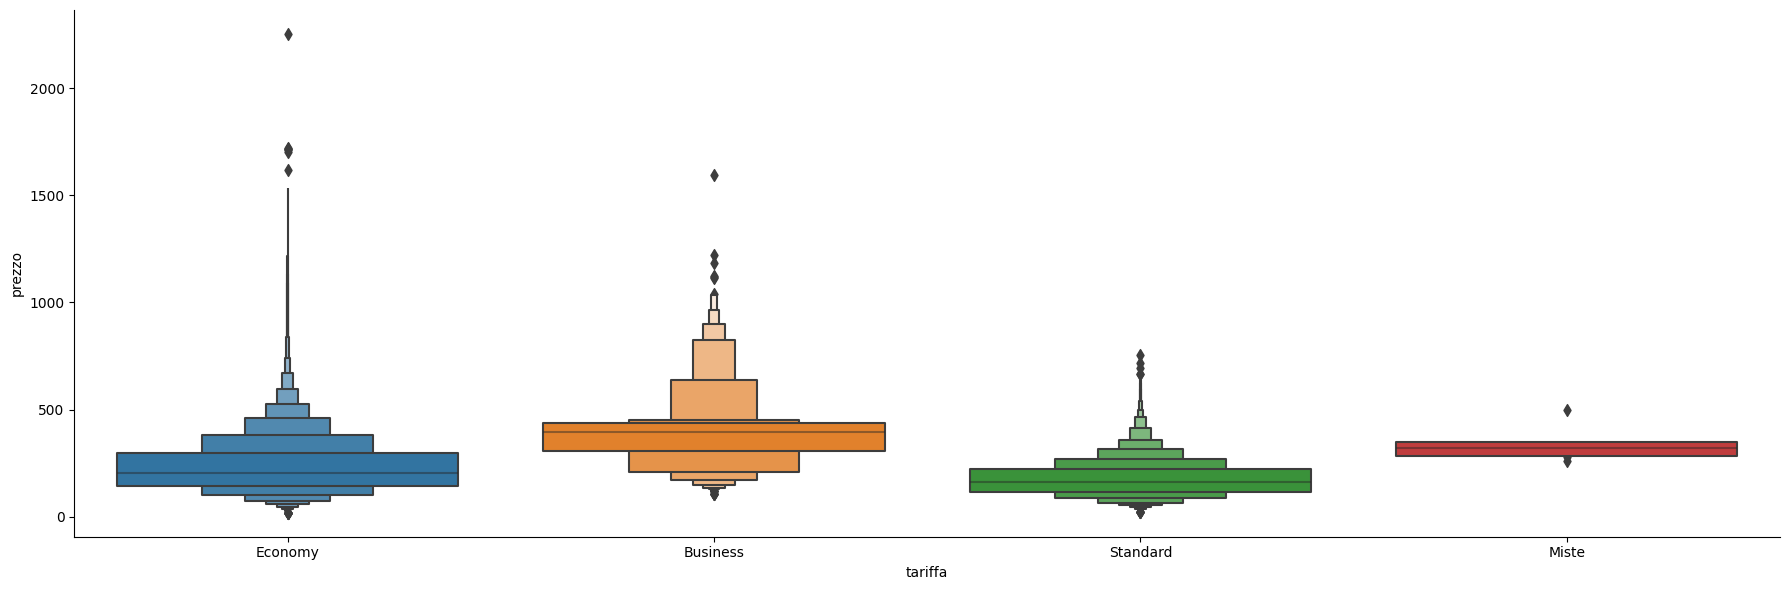

In [22]:
# tariff type vs price
sns.catplot(y = "prezzo", x= 'tariffa', data = data.sort_values("prezzo", ascending = False), kind="boxen", height = 6, aspect = 3)

In [23]:
#dummies for the different tariff types
dummies_tariffa = pd.get_dummies(data['tariffa'], prefix='tariffa')

data = pd.concat([data, dummies_tariffa], axis=1)
data = data.drop('tariffa', axis=1)

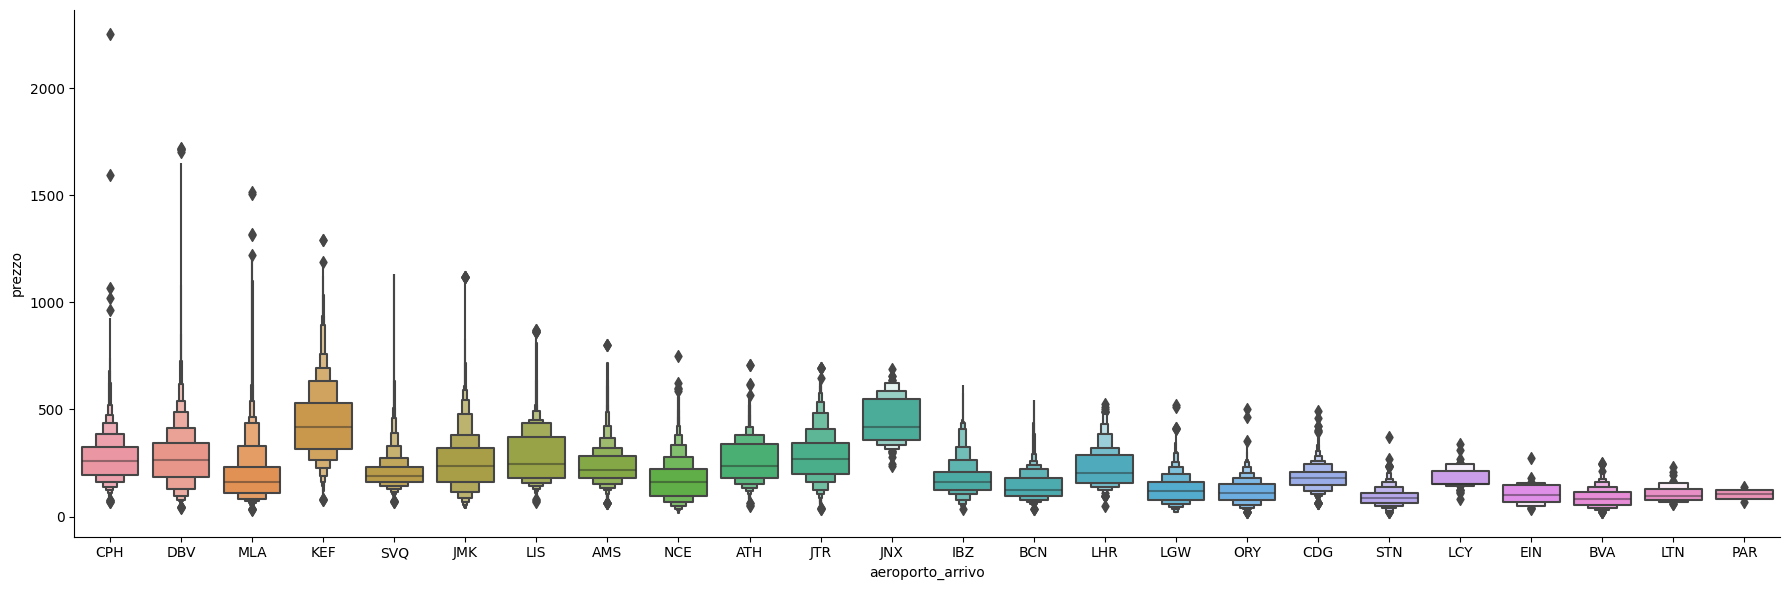

In [24]:
# destination vs price
sns.catplot(y = "prezzo", x= "aeroporto_arrivo", data = data.sort_values("prezzo", ascending = False), kind="boxen", height = 6, aspect = 3)

In [25]:
data['aeroporto_partenza'] = data['aeroporto_partenza'].replace({'ROM': 'FCO'})
dummies_aeroporto_partenza = pd.get_dummies(data['aeroporto_partenza'], prefix='aeroporto_partenza')


dummies_aeroporto_arrivo = pd.get_dummies(data['aeroporto_arrivo'], prefix='aeroporto_arrivo')
data = pd.concat([data, dummies_aeroporto_partenza, dummies_aeroporto_arrivo], axis=1)
data = data.drop(['aeroporto_partenza', 'aeroporto_arrivo'], axis=1)

# dummies_operatore = pd.get_dummies(data['operatore'], prefix='operatore')

# data = pd.concat([data, dummies_operatore], axis=1)
data['operatore'] = data['operatore'].replace({'easyJet Europe': 'easyJet'})
data['operatore'] = data['operatore'].replace({'Ryanair UK': 'Ryanair'})
data['operatore'] = data['operatore'].replace({'Transavia France': 'Transavia'})
data.loc[data['operatore'].str.contains(','), 'operatore'] = 'Multiple_Operator'

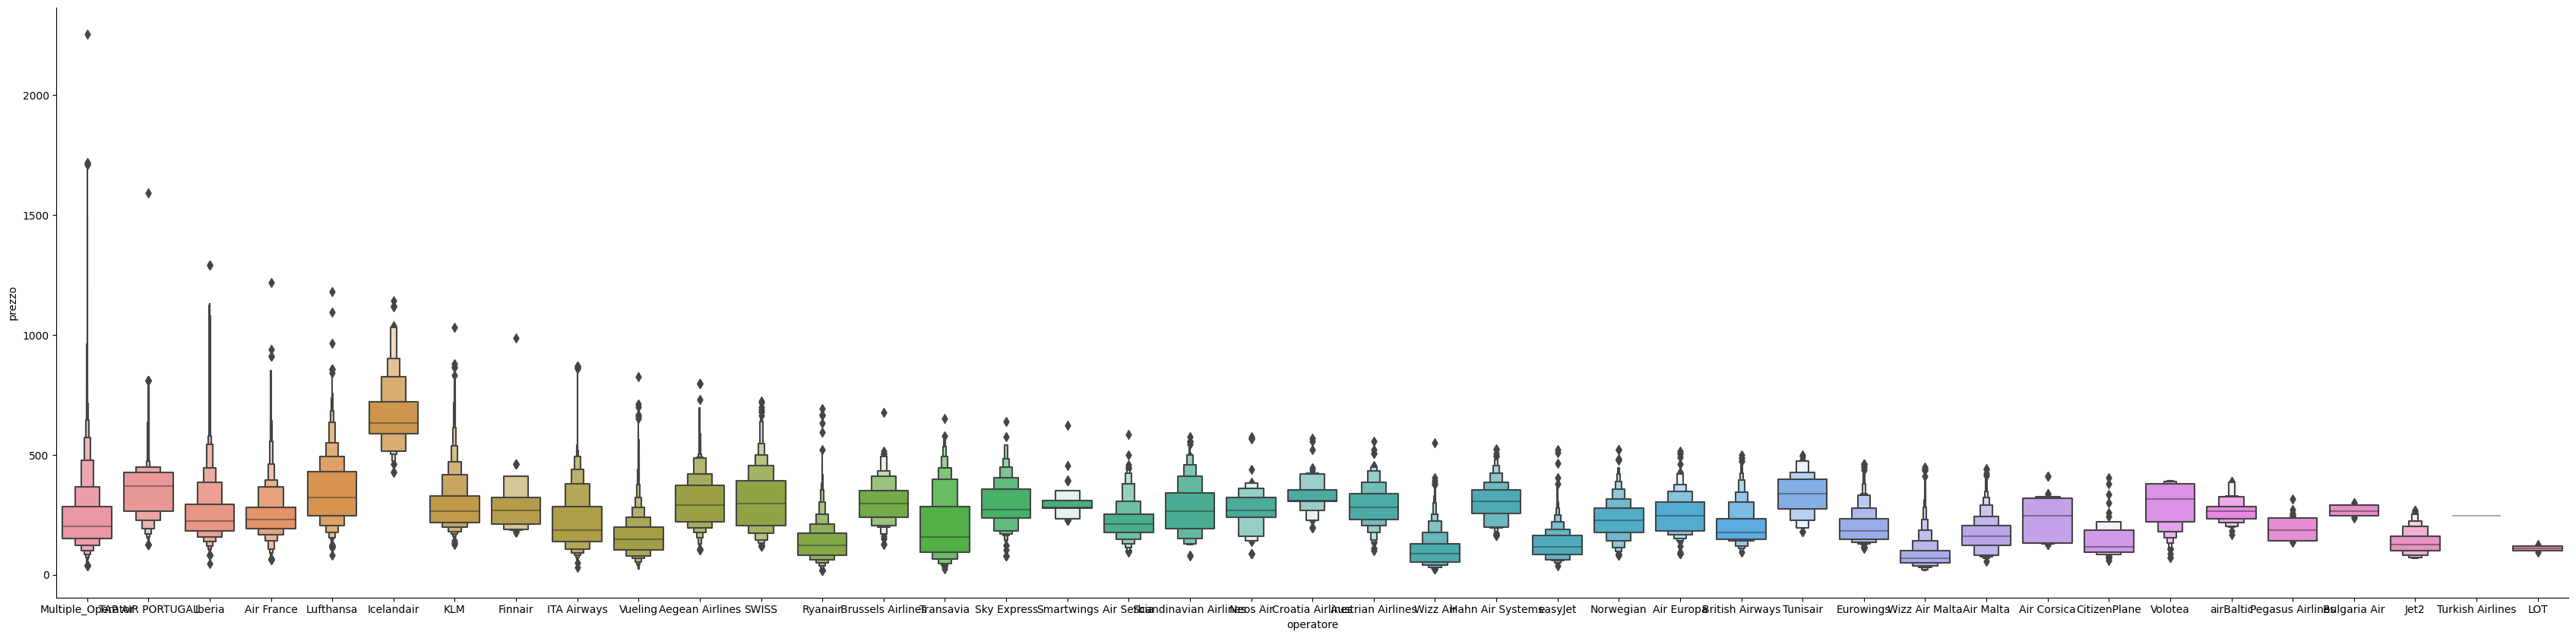

In [26]:
# flight operator vs price
sns.catplot(y = "prezzo", x= "operatore", data = data.sort_values("prezzo", ascending = False), kind="boxen", height = 8.5, aspect = 4)

In [27]:
dummy_operators = data['operatore'].str.get_dummies()
data = pd.concat([data, dummy_operators], axis=1)

data = data.drop('operatore', axis=1)

In [28]:
data['orario_partenza'] = pd.to_datetime(data['orario_partenza'])
data['orario_arrivo'] = pd.to_datetime(data['orario_arrivo'], utc=True)

/var/folders/bn/wptj_gcx0llfvd63nv5lykrr0000gn/T/ipykernel_76203/3511801520.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['orario_partenza'] = pd.to_datetime(data['orario_partenza'])
/var/folders/bn/wptj_gcx0llfvd63nv5lykrr0000gn/T/ipykernel_76203/3511801520.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['orario_arrivo'] = pd.to_datetime(data['orario_arrivo'], utc=True)


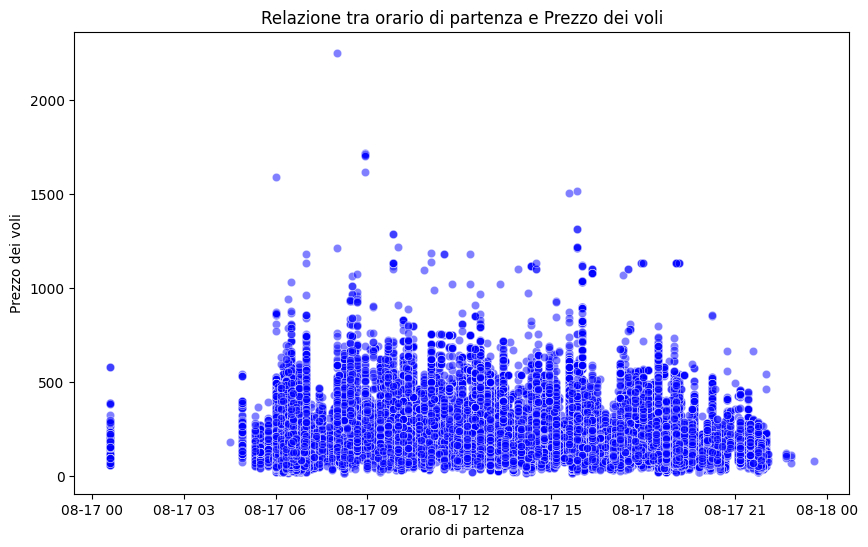

In [29]:
plt.figure(figsize=(10, 6)) 
sns.scatterplot(x=data['orario_partenza'], y=data['prezzo'], color='blue', alpha=0.5)
plt.xlabel('orario di partenza')
plt.ylabel('Prezzo dei voli')
plt.title('Relazione tra orario di partenza e Prezzo dei voli')
plt.show()

In [30]:

data['partenza_0-8'] = (data['orario_partenza'].dt.hour >= 0) & (data['orario_partenza'].dt.hour < 8)
data['partenza_8-16'] = (data['orario_partenza'].dt.hour >= 8) & (data['orario_partenza'].dt.hour < 16)
data['partenza_16-24'] = (data['orario_partenza'].dt.hour >= 16) & (data['orario_partenza'].dt.hour < 24)


data['arrivo_0-8'] = (data['orario_arrivo'].dt.hour >= 0) & (data['orario_arrivo'].dt.hour < 8)
data['arrivo_8-16'] = (data['orario_arrivo'].dt.hour >= 8) & (data['orario_arrivo'].dt.hour < 16)
data['arrivo_16-24'] = (data['orario_arrivo'].dt.hour >= 16) & (data['orario_arrivo'].dt.hour < 24)


data['partenza_0-8'] = data['partenza_0-8'].astype(int)
data['partenza_8-16'] = data['partenza_8-16'].astype(int)
data['partenza_16-24'] = data['partenza_16-24'].astype(int)

data['arrivo_0-8'] = data['arrivo_0-8'].astype(int)
data['arrivo_8-16'] = data['arrivo_8-16'].astype(int)
data['arrivo_16-24'] = data['arrivo_16-24'].astype(int)

<Figure size 1000x600 with 0 Axes>

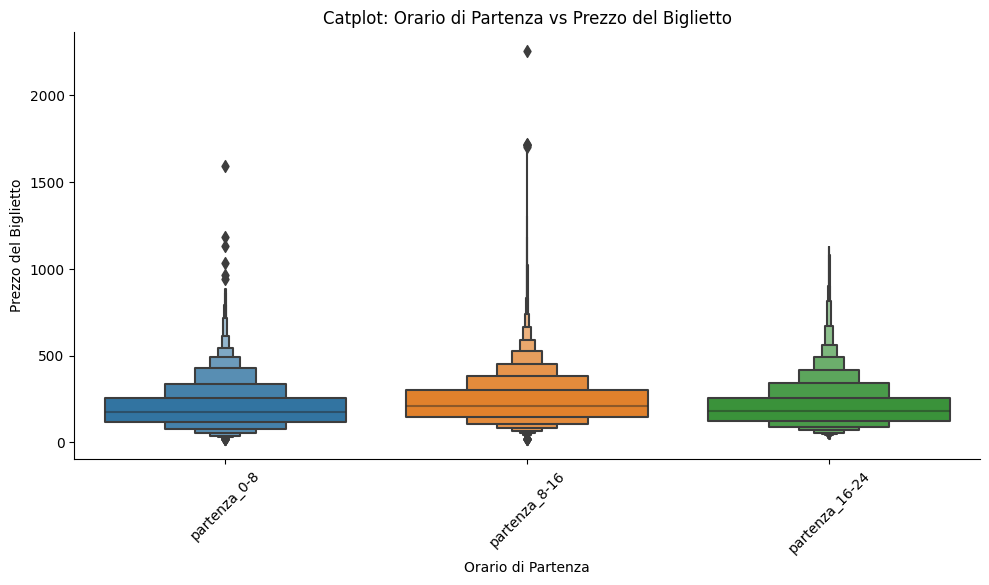

In [31]:
# Trasformazione dei dati in formato "tidy"
data_tidy = data.melt(id_vars=["prezzo"], value_vars=["partenza_0-8", "partenza_8-16", "partenza_16-24"],
                       value_name="Fascia Oraria", var_name="Orario di Partenza")

# Filtra i dati per considerare solo le fasce orarie con valore 1
data_filtered = data_tidy[data_tidy["Fascia Oraria"] == 1]

# Creazione del catplot
plt.figure(figsize=(10, 6))
sns.catplot(x="Orario di Partenza", y="prezzo", data=data_filtered, kind="boxen", height=5, aspect=2)
plt.xlabel("Orario di Partenza")
plt.ylabel("Prezzo del Biglietto")
plt.title("Catplot: Orario di Partenza vs Prezzo del Biglietto")
plt.xticks(rotation=45)
plt.show()


In [32]:
def map_numero_giorno(numero_giorno):
    if 24 <= numero_giorno <= 30:
        return 1
    elif numero_giorno==31 or numero_giorno==1 or numero_giorno==2 or numero_giorno==3 or numero_giorno==4 or numero_giorno==5 or numero_giorno==6:
        return 2
    elif 7 <= numero_giorno <= 13:
        return 3
    elif 14 <= numero_giorno <= 20:
        return 4
    else:
        return None 

data['giorno_settimana'] = data['data_partenza'].apply(lambda x: x.split()[0])
data['numero_giorno'] = data['data_partenza'].apply(lambda x: int(x.split()[1].split('/')[0]))
data['numero_mese'] = data['data_partenza'].apply(lambda x: int(x.split('/')[1]))

data['colonna_personalizzata'] = data['numero_giorno'].apply(map_numero_giorno)


In [39]:
def map_numero_giorno(numero_giorno):
    if 24 <= numero_giorno <= 30:
        return 1
    elif numero_giorno==31 or numero_giorno==1 or numero_giorno==2 or numero_giorno==3 or numero_giorno==4 or numero_giorno==5 or numero_giorno==6:
        return 2
    elif 7 <= numero_giorno <= 13:
        return 3
    elif 14 <= numero_giorno <= 20:
        return 4
    else:
        return None

data['giorno_settimana'] = data['data_partenza'].apply(lambda x: x.split()[0])
data['numero_giorno'] = data['data_partenza'].apply(lambda x: int(x.split()[1].split('/')[0]))
data['numero_mese'] = data['data_partenza'].apply(lambda x: int(x.split('/')[1]))

data['colonna_personalizzata'] = data['numero_giorno'].apply(map_numero_giorno)

# Conta le occorrenze dei valori 1, 2, 3, 4, 5 e 6 nella colonna 'colonna_personalizzata'
conteggio_1 = data['colonna_personalizzata'].astype(str).apply(lambda x: x.count('1')).sum()
conteggio_2 = data['colonna_personalizzata'].astype(str).apply(lambda x: x.count('2')).sum()
conteggio_3 = data['colonna_personalizzata'].astype(str).apply(lambda x: x.count('3')).sum()
conteggio_4 = data['colonna_personalizzata'].astype(str).apply(lambda x: x.count('4')).sum()


print("Il valore '1' appare", conteggio_1, "volte nella colonna 'colonna_personalizzata'.")
print("Il valore '2' appare", conteggio_2, "volte nella colonna 'colonna_personalizzata'.")
print("Il valore '3' appare", conteggio_3, "volte nella colonna 'colonna_personalizzata'.")
print("Il valore '4' appare", conteggio_4, "volte nella colonna 'colonna_personalizzata'.")



Il valore '1' appare 19270 volte nella colonna 'colonna_personalizzata'.
Il valore '2' appare 18976 volte nella colonna 'colonna_personalizzata'.
Il valore '3' appare 19077 volte nella colonna 'colonna_personalizzata'.
Il valore '4' appare 18798 volte nella colonna 'colonna_personalizzata'.


In [37]:
data['colonna_personalizzata']

0        1
1        1
2        1
3        1
4        1
        ..
86485    4
86486    4
86487    4
86491    4
86492    4
Name: colonna_personalizzata, Length: 76121, dtype: int64

In [42]:

conteggio = data['colonna_personalizzata'].astype(str).apply(lambda x: x.count('2')).sum()

print("Il valore '2.0' appare", conteggio, "volte nella colonna 'colonna_personalizzata'.")


Il valore '2.0' appare 18976 volte nella colonna 'colonna_personalizzata'.


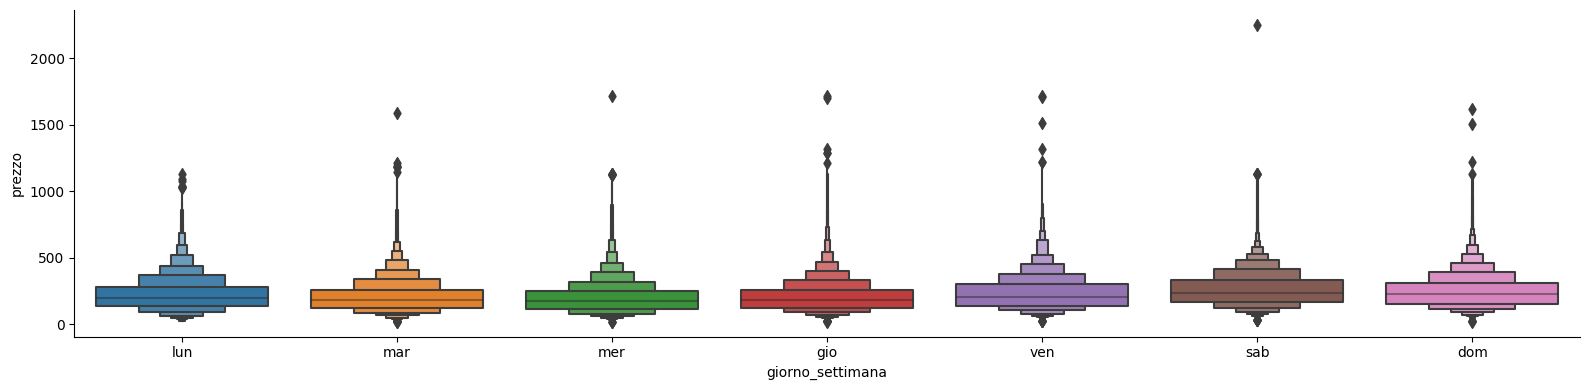

In [33]:
# day of the week vs price, fai anche per il resto
sns.catplot(y = "prezzo", x= "giorno_settimana", data = data.sort_values("prezzo", ascending = False), kind="boxen", height = 4, aspect = 4, order=['lun','mar','mer','gio','ven','sab','dom'])

In [34]:
giorno_settimana_dummy = pd.get_dummies(data['giorno_settimana'])
settimana_dummy = pd.get_dummies(data['colonna_personalizzata'], prefix='settimana')
mese_dummy = pd.get_dummies(data['numero_mese'], prefix='mese')


data = pd.concat([data, giorno_settimana_dummy, settimana_dummy, mese_dummy], axis=1)


data.drop(['giorno_settimana', 'numero_giorno', 'numero_mese', 'colonna_personalizzata'], axis=1, inplace=True)

In [35]:
df = pd.DataFrame(data)
# Funzione per convertire il formato delle date nella colonna 'data_ril'
def converti_data(data):
    giorni_settimana = {'lun': 'Mon', 'mar': 'Tue', 'mer': 'Wed', 'gio': 'Thu', 'ven': 'Fri', 'sab': 'Sat', 'dom': 'Sun'}
    for giorno in giorni_settimana:
        data = data.replace(giorno, giorni_settimana[giorno])

    data = data.replace('\\', '/').replace('\'', '')
    return data

# Funzione per estrarre solo il formato '24/7' dalla colonna 'data_partenza'
def estrai_data_partenza(data):
    return data.split()[1]

# Applica le funzioni alle colonne 'data_partenza' e 'data_ril' del DataFrame 'data'
data['data_partenza'] = data['data_partenza'].apply(estrai_data_partenza)
data['data_ril'] = data['data_ril'].apply(converti_data)

def calculate_date_difference(date_partenza, date_rilevato):
    
    if date_partenza is None or date_rilevato is None:
        return None

    
    date_partenza_obj = datetime.strptime(date_partenza, '%d/%m')
    date_rilevato_obj = datetime.strptime(date_rilevato, '%d/%m')

    
    diff_days = (date_rilevato_obj.replace(year=date_partenza_obj.year) - date_partenza_obj).days

    return abs(diff_days) 

# data['data_partenza'] = data['data_partenza'].apply(format_date_partenza)
# data['data_ril'] = data['data_ril'].apply(format_date_rilevato)


data['differenza_giorni'] = data.apply(lambda row: calculate_date_difference(row['data_partenza'], row['data_ril']), axis=1)

conteggio_celle_vuote = data['differenza_giorni'].isnull().sum()

print("Numero di celle vuote nella colonna 'differenza_giorni':", conteggio_celle_vuote)


Numero di celle vuote nella colonna 'differenza_giorni': 0


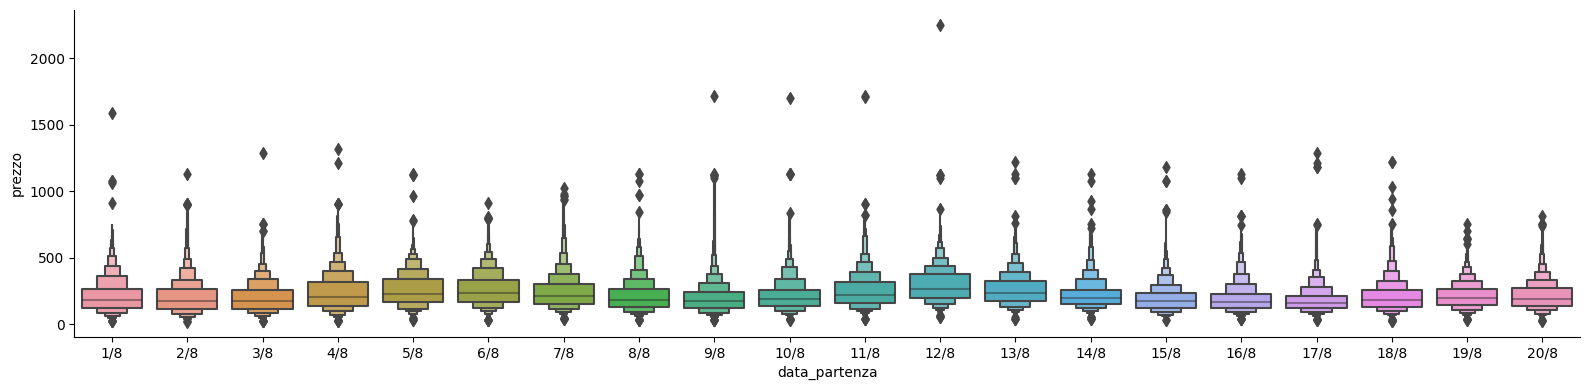

In [36]:
dates = ['1/8', '2/8', '3/8', '4/8','5/8','6/8','7/8','8/8','9/8','10/8','11/8','12/8','13/8','14/8','15/8','16/8','17/8','18/8','19/8','20/8']
sns.catplot(y="prezzo", x='data_partenza', data=data, kind="boxen", height=4, aspect=4, order=dates)


In [37]:
thresholds = [1, 3, 7, 15, 30, 60]

data['interval'] = pd.cut(data['differenza_giorni'], bins=[0] + thresholds + [float('inf')])

dummy_columns = pd.get_dummies(data['interval'], prefix='Differenza')

data = pd.concat([data, dummy_columns], axis=1)

In [38]:
data = data.drop('orario_partenza', axis=1)
data = data.drop('interval', axis=1)
data = data.drop('orario_arrivo', axis=1)
data = data.drop('data_ril', axis=1)
data = data.drop('data_partenza', axis=1)
data = data.drop('differenza_giorni', axis=1)
output_file = "Voli.xlsx"
#data.to_excel(output_file, index=False)

KeyboardInterrupt: 

Once we have build our dataset we can start to analyze it further.

Following stesps:
* Outliers removal
* data visualization
* diagnostic 
* features selection

## Outliers removal


In [ ]:
data = pd.read_excel('Voli.xlsx')

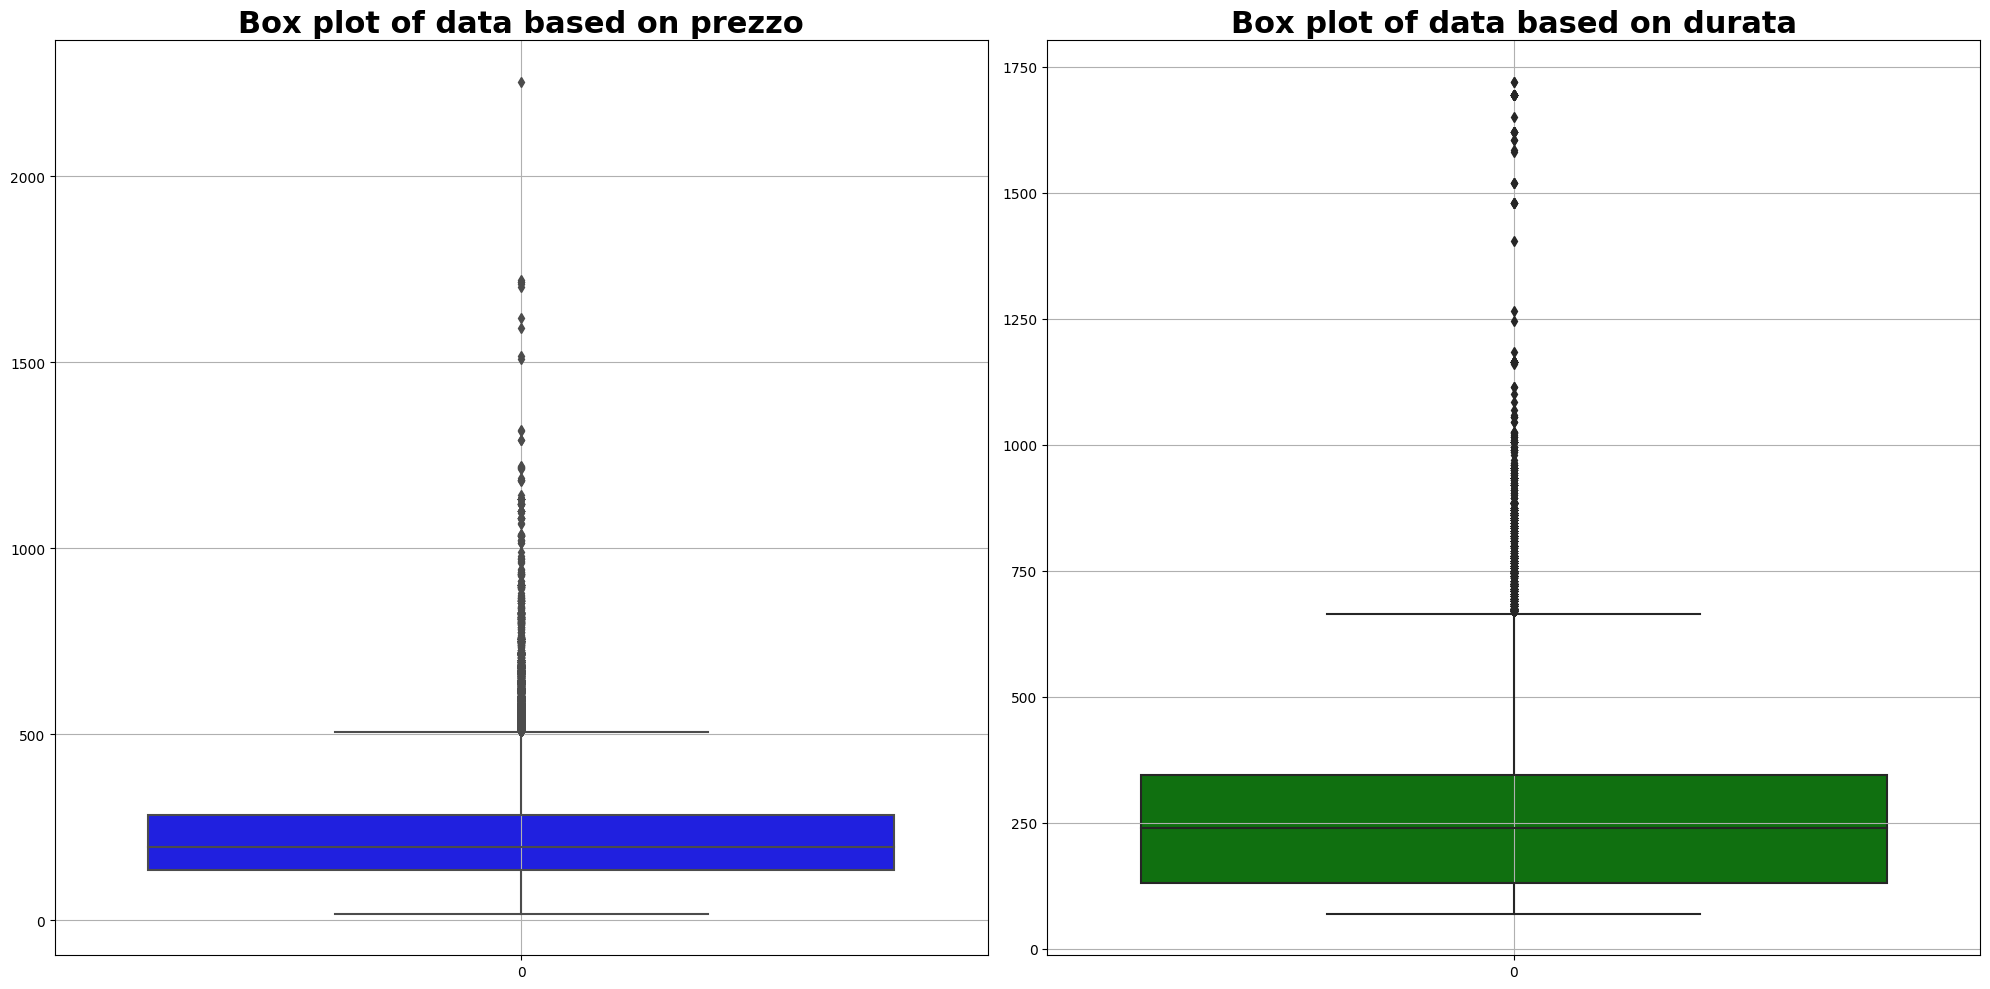

In [46]:
# Box-plots of some principal, non-binary, features. As already seen, on the right side of the plots we notice several outliers
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
features = ['prezzo','durata']
colors = ['b', 'g'] #['b', 'g', 'm', 'c', 'r']
for row_idx in range(1):
    k = row_idx
    for col_idx in range(2): 
        current = axes[col_idx]
        target = col_idx + k
        
        if target == 5:
            continue
        
        featureName = features[target]

        sns.boxplot(data.loc[:, featureName], ax = current, color = colors[target])
        

        current.set_title(f"Box plot of data based on {featureName}", fontweight = "bold", fontsize = 22 )
        current.grid()
        
fig.tight_layout()

In [48]:
upper_bound_price = np.percentile(data.loc[:, 'prezzo'], 95)
upper_bound_dimension = np.percentile(data.loc[:, 'durata'], 95)

# We now drop some of the outliers (the 5% with the highest dimensions and prices)

for i in data.index:
    if data.loc[i, 'prezzo'] > upper_bound_price:
        data = data.drop(i)
        continue
    if data.loc[i, 'durata'] > upper_bound_dimension:
        data = data.drop(i)

In [51]:
#output_file = "FlightNS1.xlsx"
#data.to_excel(output_file, index=False)

In [4]:
from sklearn.preprocessing import StandardScaler

columns_to_standardize = ['distanza', 'durata']
scaler = StandardScaler()
data[columns_to_standardize] = scaler.fit_transform(data[columns_to_standardize])


In [8]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['distanza', 'durata']
scaler = MinMaxScaler()
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])


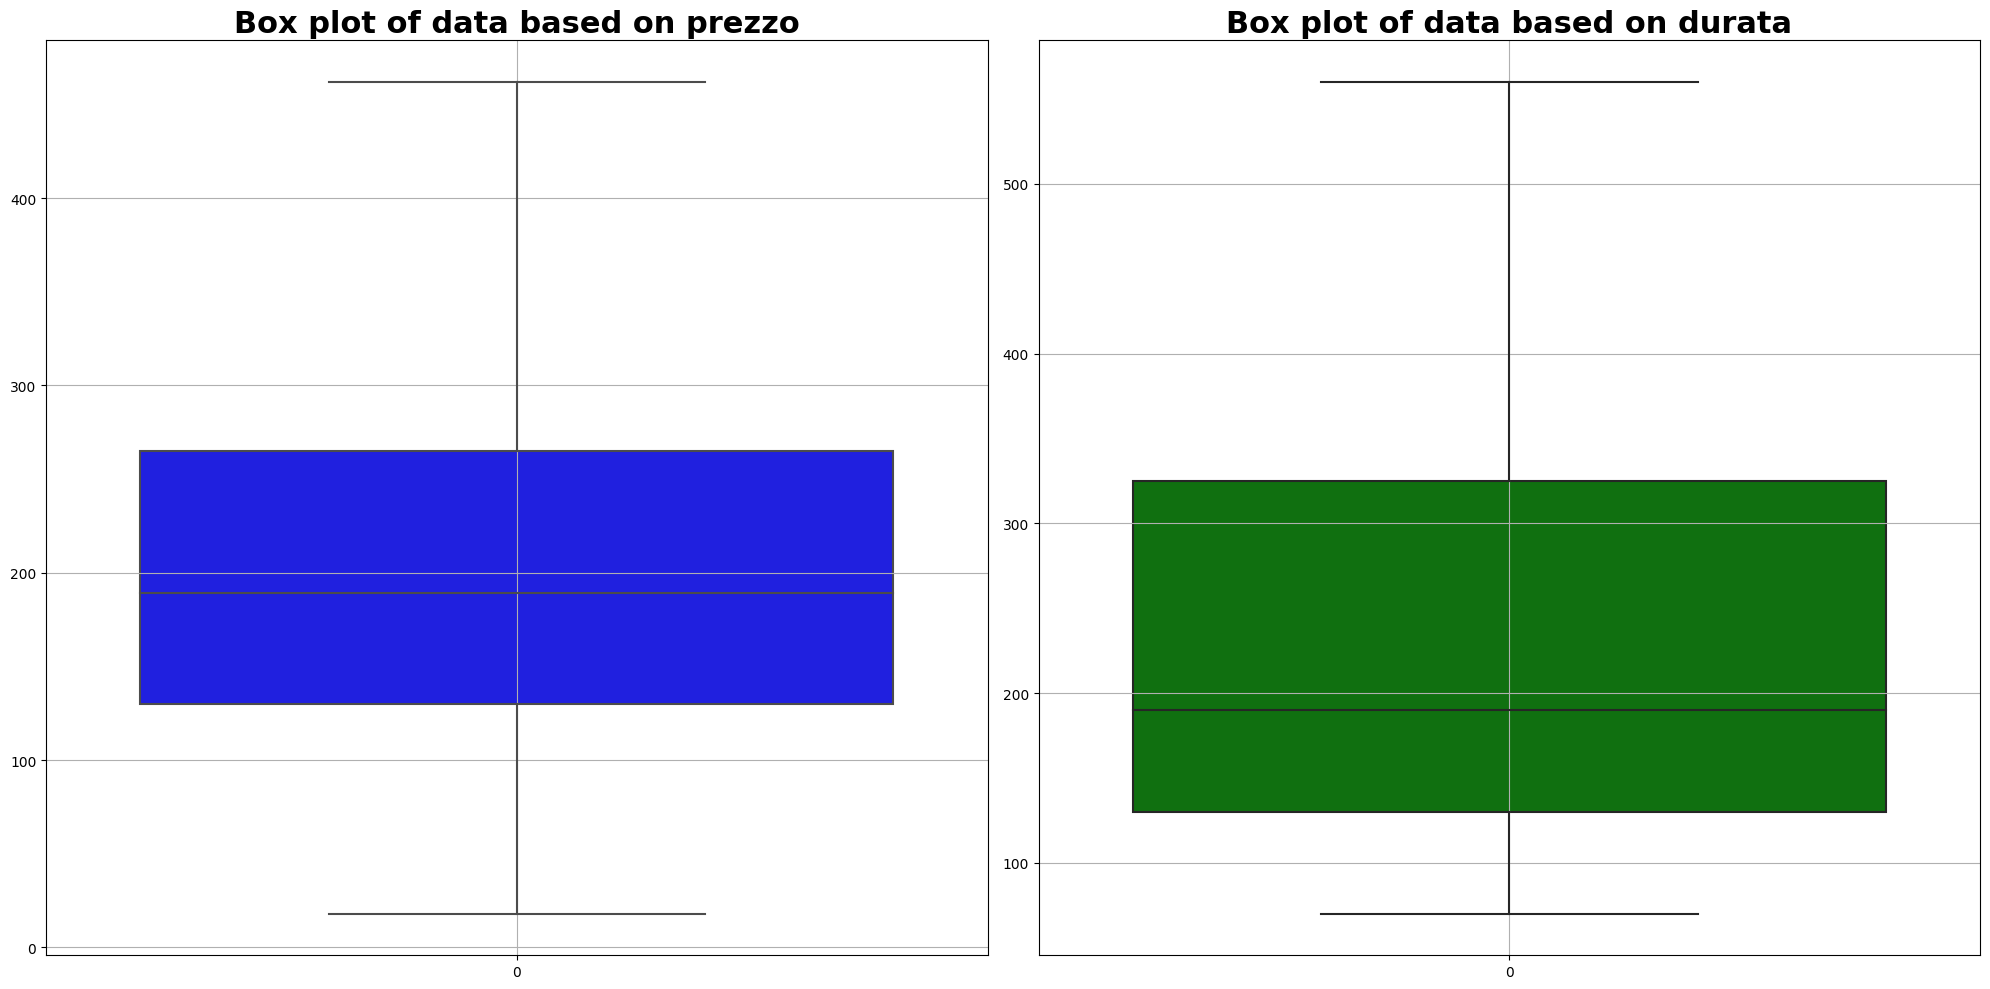

In [49]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
features = ['prezzo','durata']
colors = ['b', 'g'] #['b', 'g', 'm', 'c', 'r']
for row_idx in range(1):
    k = row_idx
    for col_idx in range(2): 
        current = axes[col_idx]
        target = col_idx + k
        
        if target == 5:
            continue
        
        featureName = features[target]

        sns.boxplot(data.loc[:, featureName], ax = current, color = colors[target])
        

        current.set_title(f"Box plot of data based on {featureName}", fontweight = "bold", fontsize = 22 )
        current.grid()
        
fig.tight_layout()

In [10]:
#output_file = "FlightS.xlsx"
#data.to_excel(output_file, index=False)

## Features Selection

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
import random                                    
from math import isnan
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer


from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from datetime import datetime
import re
import os

In [3]:
data = pd.read_excel('FlightNS.xlsx')

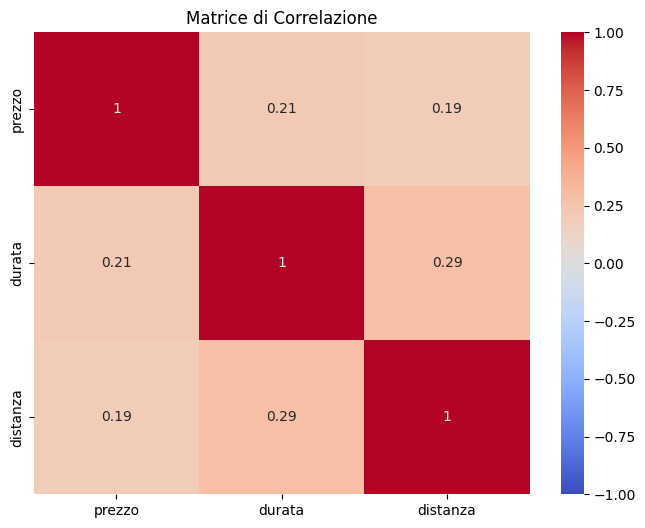

In [50]:
correlation_matrix = data[['prezzo', 'durata', 'distanza']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice di Correlazione')
plt.show()

In [51]:
#count the number of occurrencies of each airline
airline_counts = data.loc[:, 'Aegean Airlines':'easyJet'].sum().sort_values(ascending=False)
print(airline_counts)
airline_counts = airline_counts.reset_index()

Multiple_Operator        13464
Vueling                  10425
ITA Airways               7922
Ryanair                   5604
Iberia                    4437
Lufthansa                 2916
KLM                       2878
Wizz Air Malta            2613
easyJet                   2097
Aegean Airlines           1952
Air France                1496
TAP AIR PORTUGAL          1399
Wizz Air                  1242
Sky Express               1227
Transavia                  987
Scandinavian Airlines      986
Air Malta                  949
Norwegian                  819
Hahn Air Systems           771
Volotea                    708
British Airways            693
Eurowings                  670
SWISS                      662
Air Serbia                 360
Austrian Airlines          246
Air Europa                 229
Jet2                       224
airBaltic                  193
Brussels Airlines          173
Finnair                    113
Croatia Airlines            96
Neos Air                    85
Tunisair

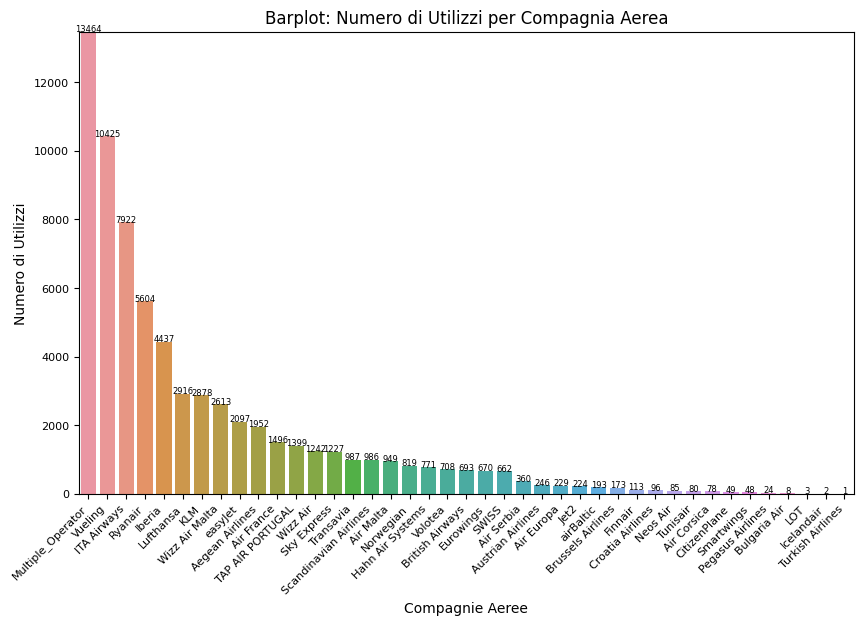

In [52]:
%matplotlib inline
# Creazione del barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='index', y=0, data=airline_counts)

plt.xlabel("Compagnie Aeree")
plt.ylabel("Numero di Utilizzi")

plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)  
plt.ylim(0, max(airline_counts[0]) + 5)  
for i, v in enumerate(airline_counts[0]):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=6)  
plt.title("Barplot: Numero di Utilizzi per Compagnia Aerea")
plt.show()

In [56]:

columns_to_drop = ['CitizenPlane', 'Smartwings', 'Pegasus Airlines', 'Bulgaria Air', 'LOT', 'Icelandair', 'Turkish Airlines']

data.drop(columns=columns_to_drop, inplace=True)


In [ ]:
#identify input features X and response y
y = data['prezzo']
 #Load X Variables into a Pandas Dataframe with columns 
copy_data = data.copy()
X = copy_data.drop(['prezzo'], axis = 1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3) 

In [9]:
#Chi-square
#Perform chi2 test
from sklearn.feature_selection import chi2 
#Calculating Fscore and p value
f_p_values=chi2(X_train,y_train)
#F_p_values
#Representing in list form
import pandas as pd
p_values=pd.Series(f_p_values[1])
p_values.index=X_train.columns
#P_values        
#Sorting values in ascending order
p_values.sort_index(ascending=False)


tipo                        0.000000e+00
durata                      0.000000e+00
distanza                    0.000000e+00
tariffa_Business            0.000000e+00
tariffa_Economy             1.932205e-90
                               ...      
Differenza_(3.0, 7.0]       2.531193e-88
Differenza_(7.0, 15.0]     1.000362e-108
Differenza_(15.0, 30.0]     1.472094e-55
Differenza_(30.0, 60.0]    2.366610e-107
Differenza_(60.0, inf]     3.939784e-136
Length: 92, dtype: float64

In [57]:
conteggio_uno = data['Differenza_(0.0, 1.0]'].value_counts()[1] #???????

print(f"Il valore 1 compare {conteggio_uno} volte nella colonna 'operatore'.")

Il valore 1 compare 176 volte nella colonna 'operatore'.


<Axes: >

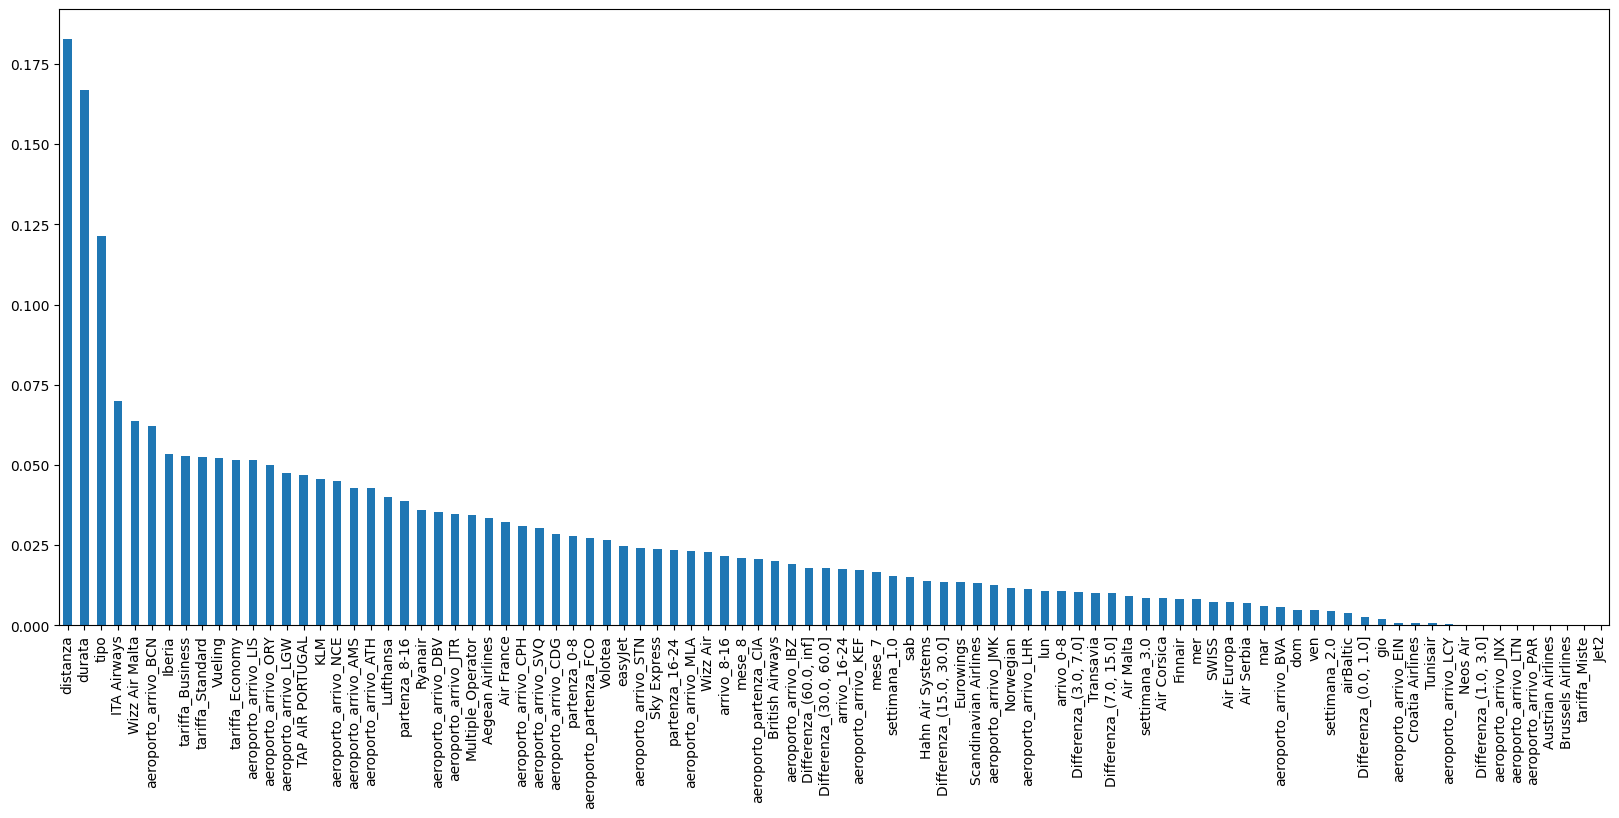

In [15]:
#Now let’s learn the third very important technique i.e feature selection by using mutual information gain.
#Mutual information gain
#Importing mutual information gain
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

#plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [16]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

feat = X
price = y

selector = SelectKBest(score_func=mutual_info_regression, k='all')
X_selected = selector.fit_transform(feat, price)

feature_scores = selector.scores_

feature_ranking = sorted(list(zip(feat.columns, feature_scores)), key=lambda x: x[1], reverse=True)

for rank, (feature, score) in enumerate(feature_ranking, start=1):
    print(f"Rank {rank}: Feature '{feature}' - Score: {score}")

# Ottieni gli indici delle prime 80 variabili più importanti
selected_indices = (-X_selected).argsort()[:, :80]

# Seleziona solo le prime 80 variabili
feat_selected = feat.iloc[:, selected_indices[0]]

# Crea un nuovo DataFrame con le prime 80 variabili selezionate
data = pd.concat([feat_selected, price], axis=1)

Rank 1: Feature 'distanza' - Score: 0.1775860033619434
Rank 2: Feature 'durata' - Score: 0.15846227074318353
Rank 3: Feature 'tipo' - Score: 0.11924196389638153
Rank 4: Feature 'ITA Airways' - Score: 0.06375078845284676
Rank 5: Feature 'Wizz Air Malta' - Score: 0.0629001326520573
Rank 6: Feature 'aeroporto_arrivo_BCN' - Score: 0.06227466014324401
Rank 7: Feature 'tariffa_Business' - Score: 0.05582930396578423
Rank 8: Feature 'aeroporto_arrivo_LIS' - Score: 0.05211551312336882
Rank 9: Feature 'tariffa_Standard' - Score: 0.04984530419174282
Rank 10: Feature 'tariffa_Economy' - Score: 0.04885911572032242
Rank 11: Feature 'Vueling' - Score: 0.048629607502779226
Rank 12: Feature 'aeroporto_arrivo_LGW' - Score: 0.04593977995655463
Rank 13: Feature 'TAP AIR PORTUGAL' - Score: 0.04570080776452201
Rank 14: Feature 'Iberia' - Score: 0.04509131194046789
Rank 15: Feature 'aeroporto_arrivo_ORY' - Score: 0.04435547123332739
Rank 16: Feature 'aeroporto_arrivo_ATH' - Score: 0.04425310693719764
Rank 17

In [20]:
from sklearn.feature_selection import SelectKBest, f_regression
feat = X
price = y

selector = SelectKBest(score_func=f_regression, k='all')

X_selected = selector.fit_transform(feat, price)

feature_scores = selector.scores_

feature_ranking = sorted(list(zip(feat.columns, feature_scores)), key=lambda x: x[1], reverse=True)

for rank, (feature, score) in enumerate(feature_ranking, start=1):
    print(f"Rank {rank}: Feature '{feature}' - Score: {score}")


Rank 1: Feature 'tipo' - Score: 4857.017168850091
Rank 2: Feature 'Wizz Air Malta' - Score: 4482.783180393525
Rank 3: Feature 'tariffa_Business' - Score: 3903.895522042415
Rank 4: Feature 'aeroporto_arrivo_ORY' - Score: 3453.37557084524
Rank 5: Feature 'durata' - Score: 3313.7873778037792
Rank 6: Feature 'Lufthansa' - Score: 3084.1287153226
Rank 7: Feature 'Ryanair' - Score: 3066.8650467374846
Rank 8: Feature 'TAP AIR PORTUGAL' - Score: 2988.109073754013
Rank 9: Feature 'Vueling' - Score: 2951.0327114287998
Rank 10: Feature 'aeroporto_arrivo_LGW' - Score: 2866.784683488296
Rank 11: Feature 'aeroporto_arrivo_BCN' - Score: 2658.7219512821116
Rank 12: Feature 'distanza' - Score: 2520.942049034765
Rank 13: Feature 'tariffa_Standard' - Score: 2466.6648532193476
Rank 14: Feature 'aeroporto_arrivo_LIS' - Score: 2400.2961589746674
Rank 15: Feature 'aeroporto_arrivo_KEF' - Score: 2340.7811703512625
Rank 16: Feature 'aeroporto_arrivo_STN' - Score: 2144.8819400519205
Rank 17: Feature 'aeroporto_p

In [18]:
# Checking for Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(z):
    # Calculating Variable Inflation Factor (VIF)
    vif = pd.DataFrame()
    vif["variables"] = z.columns
    vif["VIF"] = [variance_inflation_factor(z.values, i) for i in range(z.shape[1])]
    return(vif)

# Compute VIF on X
calc_vif(X)

c:\Users\loren\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,tipo,7.154199
1,durata,6.233468
2,distanza,256.839247
3,tariffa_Business,inf
4,tariffa_Economy,inf
...,...,...
87,"Differenza_(3.0, 7.0]",inf
88,"Differenza_(7.0, 15.0]",inf
89,"Differenza_(15.0, 30.0]",inf
90,"Differenza_(30.0, 60.0]",inf


In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression

max_features = len(feat.columns)

# Inizializza un modello di regressione lineare
model = LinearRegression()

best_score = 0
best_k = 0

for k in range(1, max_features + 1):
    selector = SelectKBest(score_func=f_regression, k=k)
    X_selected = selector.fit_transform(feat, price)
    
    # Utilizza la cross-validation per valutare le prestazioni del modello
    scores = cross_val_score(model, X_selected, price, cv=5, scoring='neg_mean_squared_error')
    avg_score = -np.mean(scores)
    
    # Aggiorna il miglior punteggio e il miglior numero di features
    if avg_score > best_score:
        best_score = avg_score
        best_k = k

# Seleziona le migliori features utilizzando il miglior numero di features
selector = SelectKBest(score_func=f_regression, k=best_k)
X_selected = selector.fit_transform(feat, price)
selected_features = feat.columns[selector.get_support()]

print(f"Miglior numero di features: {best_k}")
print(f"Migliori features: {selected_features}")


Miglior numero di features: 53
Migliori features: Index(['tipo', 'durata', 'distanza', 'tariffa_Business', 'tariffa_Economy',
       'tariffa_Standard', 'aeroporto_partenza_CIA', 'aeroporto_partenza_FCO',
       'aeroporto_arrivo_AMS', 'aeroporto_arrivo_ATH', 'aeroporto_arrivo_BCN',
       'aeroporto_arrivo_BVA', 'aeroporto_arrivo_CPH', 'aeroporto_arrivo_DBV',
       'aeroporto_arrivo_IBZ', 'aeroporto_arrivo_JMK', 'aeroporto_arrivo_JTR',
       'aeroporto_arrivo_KEF', 'aeroporto_arrivo_LGW', 'aeroporto_arrivo_LIS',
       'aeroporto_arrivo_MLA', 'aeroporto_arrivo_NCE', 'aeroporto_arrivo_ORY',
       'aeroporto_arrivo_STN', 'Aegean Airlines', 'Air France',
       'Austrian Airlines', 'Hahn Air Systems', 'Iberia', 'KLM', 'Lufthansa',
       'Ryanair', 'SWISS', 'Scandinavian Airlines', 'Sky Express',
       'TAP AIR PORTUGAL', 'Volotea', 'Vueling', 'Wizz Air', 'Wizz Air Malta',
       'easyJet', 'partenza_0-8', 'partenza_8-16', 'partenza_16-24',
       'arrivo_0-8', 'arrivo_8-16', 'arrivo

In [30]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor() #model initialization
tree_model.fit(feat, price)

feature_importances = tree_model.feature_importances_
selected_features = feat.columns[feature_importances >= 0.0001] #select only those features with a threshold above 0.0001

#Visualize features and their importance
print("Features importance according to regression tree:")
#for feature, importance in zip(feat.columns, feature_importances):
    #print(f"Feature '{feature}': {importance:.4f}")
sorted_features = [feature for _, feature in sorted(zip(feature_importances, feat.columns), reverse=True)]
#print("Importanza delle features ordinate:")
for feature in sorted_features:
    print(f"Feature '{feature}': {feature_importances[feat.columns.get_loc(feature)]:.4f}")

print("Selected features:")
print(selected_features)

num_selected_features = len(selected_features)
print(f"Number of selected features: {num_selected_features}")



NameError: name 'feat' is not defined

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

alpha = 1.0  
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train, y_train)

feature_importance = np.abs(ridge_model.coef_)

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeatures importance:")
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Importance']):
    print(f"{feature}: {importance}")

test_score = ridge_model.score(X_test, y_test)
print("\nR^2 score on test set:", test_score)



Importanza delle features:
aeroporto_arrivo_JNX: 162.50633613263307
Wizz Air: 120.95339306060768
aeroporto_arrivo_KEF: 120.30712887303031
Wizz Air Malta: 116.56918320817667
Tunisair: 87.38949368500485
Eurowings: 85.34185646414329
Jet2: 80.67536414665405
aeroporto_arrivo_DBV: 79.9789807812639
Finnair: 76.67639586313324
tariffa_Business: 74.08984164281188
aeroporto_arrivo_JTR: 72.84573378721089
aeroporto_arrivo_JMK: 69.63939421952401
aeroporto_arrivo_ATH: 63.97278765409596
Differenza_(0.0, 1.0]: 62.642292342088616
Vueling: 61.62831932689942
TAP AIR PORTUGAL: 60.967193389276986
Transavia: 56.88005241204074
Air Serbia: 54.945634300586086
Iberia: 53.63147992172196
aeroporto_arrivo_CPH: 52.30698386891845
tipo: 49.335315112542396
Differenza_(1.0, 3.0]: 47.69415382472478
tariffa_Standard: 47.186467992172034
aeroporto_arrivo_LIS: 47.17996650852082
Multiple_Operator: 43.44270880075218
aeroporto_arrivo_LCY: 42.74228277485547
Volotea: 40.94042675600663
Brussels Airlines: 40.506571081189506
Croati

With the help of this function, we can select highly correlated features. The purpose is to select the correlated features and then remove them. If you note then we have written abs means absolute, because we will get a negative correlation also which will convert into a positive.

Chi-square is used to find F-score and p-values for all features. So in this case the first array is for F score and the second array is for p- values. Now, what is the importance of these two values? And the more the value of the F score the more important the feature is and the lesser the value of the p-value the more important will be the feature.

mutual_info_classif is a library that is present in feature_selection. It is the property of mutual information gain that the value you will get will never be negative. The higher the value the more important that feature will be or you can say that the dependency of that independent feature will be more on the dependent feature.

## Regression Models

In [53]:
import re
import os
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import statsmodels.api as sm


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score

In [3]:
data = pd.read_excel('FlightNS.xlsx')

In [111]:
#identify input features X and response y

y = data.loc[:, 'prezzo'].values.astype('float64') #vector version
yy = data.loc[:, 'prezzo']

XX = data.copy()
XX = XX.drop(['prezzo'], axis = 1)
col_ind = list(XX.columns) #save columns = independent variables

X = XX.values.astype('float64') #matrix version

In [112]:
#defining train and test set, using their dataframe version
XX_train_p, XX_test, yy_train_p, yy_test = train_test_split(XX, yy, test_size = 0.25, random_state = 42)  
XX_train, XX_val, yy_train, yy_val = train_test_split(XX_train_p, yy_train_p, test_size = 0.25, random_state = 42)

In [172]:
#create copies of previous datasets, in order to store original version but also to apply trasmormations
x_train = XX_train.copy()
x_val = XX_val.copy()
y_t = yy_train.copy()
y_v = yy_val.copy()

In [178]:
# 50% Train - 25% Val - 25% Test --> alleni su train tutti i mod e poi valuti su val 
#poi selezioni modello più promettente e rialleni su (train+val) insieme quindi X_train_part  y_train_part e valuti su test X_test e y_test

X_train_part, X_test, y_train_part, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train_part, y_train_part, test_size=0.25, random_state = 42)

In [127]:
def model_valid(model, X_train, X_val, y_train = y_train, y_val = y_val):
    print(f'R^2 on train dataset {model.score(X_train, y_train)}')
    print(f'R^2 on validation dataset {model.score(X_val, y_val)}')
    r2 = model.score(X_val, y_val)
    n_val = len(y_val) # numero delle osservazioni
    p = len(col_ind) #numero colonne
    adjusted_r2_val = 1 - (1 - r2) * (n_val - 1) / (n_val - p - 1)
    print("Adjusted R-squared:", adjusted_r2_val)
    mae_val = mean_absolute_error(y_val,model.predict(X_val))
    print("MAE:" , mae_val)
    mse_val = mean_squared_error(y_val,model.predict(X_val))
    print("MSE:" , mse_val)
    rmse_val = mean_squared_error(y_val,model.predict(X_val), squared = False)
    print("RMSE:" , rmse_val)

In [126]:
def model_eval(model, X_train, X_val, y_train, y_val):
    print(f'R^2 on train dataset {model.score(X_train, y_train)}')
    print(f'R^2 on test dataset {model.score(X_test, y_test)}')
    r2 = model.score(X_test, y_test)
    n = len(y_test) # numero delle osservazioni
    p = len(col_ind) #numero colonne
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print("Adjusted R-squared:", adjusted_r2)
    mae = mean_absolute_error(y_test,model.predict(X_test))
    print("MAE:" , mae)
    mse = mean_squared_error(y_test,model.predict(X_test))
    print("MSE:" , mse)
    rmse = mean_squared_error(y_test,model.predict(X_test), squared = False)
    print("RMSE:" , rmse)

In [75]:
#start with simple linear regression model
cv_lin_reg = LinearRegression()

#model evaluation through cross-validation
scorer = make_scorer(r2_score, greater_is_better=True) # Defining the scorer, r^2 già quello di default
scores = cross_val_score(cv_lin_reg, X_train_part, y_train_part, scoring=scorer, cv=10)  # 10-fold cross-validation
print("Cross-validation scores:", scores)
print("Average scores:", np.mean(scores))


lin_reg = LinearRegression()
#fit the model
lin_reg.fit(X_train, y_train)
#make prediction
y_pred_lin = lin_reg.predict(X_val)

#regression coefficients
lin_reg_coef = lin_reg.coef_ 
#print(lin_reg.coef_) 

Punteggi cross-validation: [0.61533944 0.60241083 0.60131975 0.61159498 0.60513545 0.6138465
 0.59908234 0.60993676 0.59199892 0.59360468]
Media punteggi: 0.6044269640791899


In [99]:
# evaluation of performance metrics
model_valid(lin_reg)

R^2 on train dataset 0.6066778121805778
R^2 on validation dataset 0.6033106471715206
Adjusted R-squared: 0.6002170703733574
MAE: 47.87829002942499
MSE: 3786.7170800371373
RMSE: 61.53630700681621


In [161]:
import statsmodels.api as sm
#add incerpet to matrix X_train
XZ_train = sm.add_constant(X_train)

model = sm.OLS(y_train, XZ_train)
results = model.fit()
#results
print(results.summary())
y_pred_linear = results.predict(sm.add_constant(X_val)) 
mse_linear = mean_squared_error(y_val, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_val, y_pred_linear)
print("Linear Model:")
print("RMSE:", rmse_linear)
print("R-squared:", r2_linear)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     662.9
Date:                Thu, 17 Aug 2023   Prob (F-statistic):               0.00
Time:                        19:15:12   Log-Likelihood:            -2.1453e+05
No. Observations:               38772   AIC:                         4.292e+05
Df Residuals:                   38681   BIC:                         4.300e+05
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.1184      5.130     16.007      0.0

creare un grafico che ti aiuti a visualizzare i risultati della validazione incrociata e a valutare le prestazioni del modello utilizzando Python e librerie come scikit-learn e matplotlib.

La validazione incrociata è una tecnica utilizzata per stimare le prestazioni di un modello su dati non visti durante l'addestramento. Uno dei modi più comuni per farlo è la "K-Fold Cross-Validation", in cui il set di dati viene suddiviso in K parti uguali (fold), il modello viene addestrato su K-1 fold e testato sull'ultimo fold, ripetendo il processo K volte.

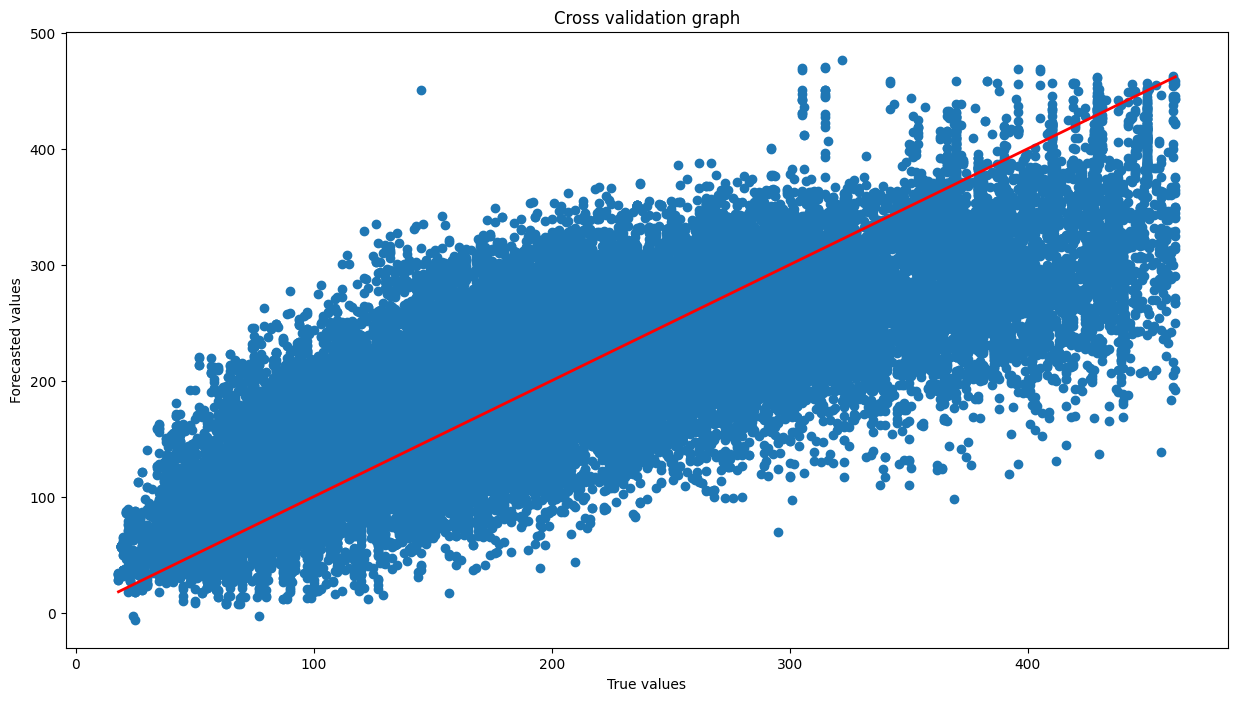

In [101]:
from sklearn.model_selection import cross_val_predict
#prediction using crossvalidation
y_pred_cv = cross_val_predict(cv_lin_reg, X_train_part, y_train_part, cv=10)  

#Plot results
plt.figure(figsize=(15, 8))
plt.scatter(y_train_part, y_pred_cv)
plt.plot([min(y_train_part), max(y_train_part)], [min(y_train_part), max(y_train_part)], color='red', linewidth=2)  #ideal line
plt.xlabel("True values")
plt.ylabel("Forecasted values")
plt.title("Cross validation graph")
plt.show()


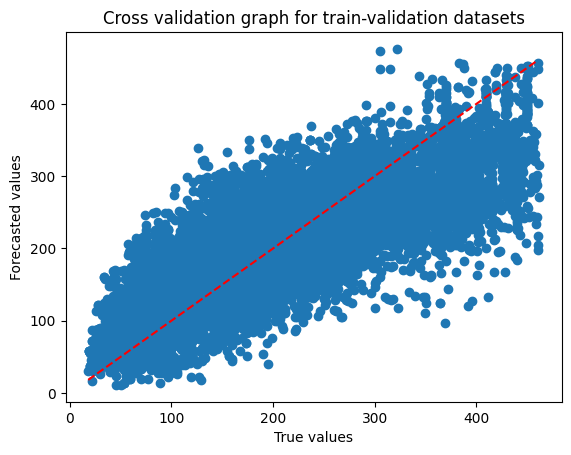

In [195]:
# PLOTTING RESULTS. Since the model is a multi-variate regression, if we want to visualize the results 
# we need to make a two-dimensional plot of points whose coordinates are (y_test , y_hat). 
# The more the points will be next to the y = x line, the more the predictor will be precise.
#for train-validation dataset
plt.scatter((y_val), (y_pred_lin))

x = np.arange(min((y_pred_lin)), max((y_pred_lin)))
plt.plot(x, x, '--', c = 'r', label = 'correct forecast')
plt.xlabel("True values")
plt.ylabel("Forecasted values")
plt.title("Cross validation graph for train-validation datasets")

plt.show()

Residui Analisys 

catter Plot dei Residui: Questo è un grafico che mostra i residui (differenze tra i valori osservati e i valori predetti dal modello) rispetto ai valori predetti. Se i residui sono distribuiti casualmente intorno allo zero senza un modello evidente, il tuo modello potrebbe essere appropriato.

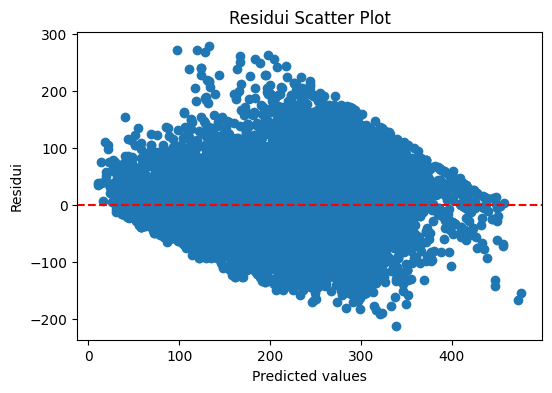

In [103]:
# residui scatterplot

residui = y_val - y_pred_lin # compute residui 

plt.figure(figsize=(6, 4))
plt.scatter(y_pred_lin, residui)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residui")
plt.title("Residui Scatter Plot")
plt.show()

Un Q-Q Plot (Quantile-Quantile Plot) è un tipo di grafico utilizzato per confrontare la distribuzione dei quantili di due insiemi di dati. In pratica, viene utilizzato per verificare se due insiemi di dati seguono approssimativamente la stessa distribuzione o se ci sono deviazioni significative. Se i punti sul Q-Q Plot seguono approssimativamente una retta, ciò suggerisce che i dati seguono approssimativamente la distribuzione specificata (nel nostro caso, una distribuzione normale). Se i punti deviano significativamente dalla retta, potrebbe indicare deviazioni dalla distribuzione teorica.

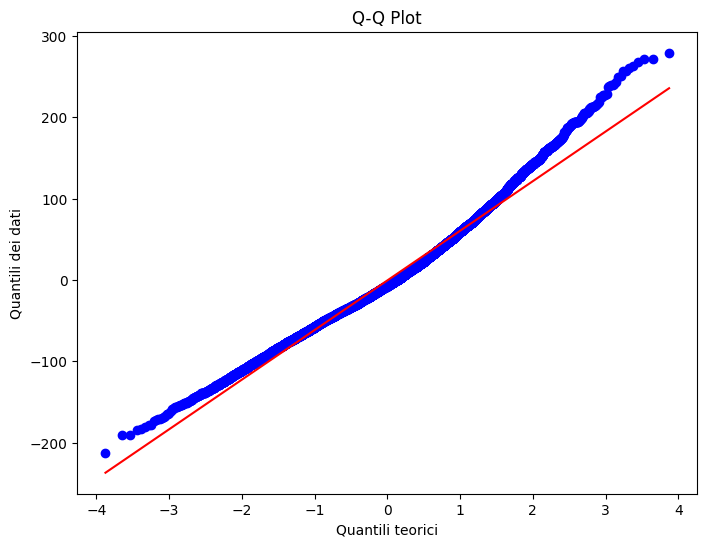

In [104]:
import scipy.stats as stats

# Creazione del Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(residui, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.xlabel("Quantili teorici")
plt.ylabel("Quantili dei dati")
plt.show()
#il fatto che devi poi identifica probabilmente outliers

Implementation of some regularization technique. We are evaluating these further model through cross-validation.

In [92]:
ridge_reg_cv = Ridge(alpha=1.0)  #tentative value
lasso_reg_cv = Lasso(alpha=1.0)  

num_folds = 5
scoring = 'neg_mean_squared_error'  #we are usinging the negative of MSE for evaluating

ridge_scores = cross_val_score(ridge_reg_cv, X_train_part, y_train_part, scoring=scoring, cv=num_folds)
lasso_scores = cross_val_score(lasso_reg_cv, X_train_part, y_train_part, scoring=scoring, cv=num_folds)

#convert negative values of MSE into positive one and apply sqrt to obtain RMSE
ridge_rmse_scores = np.sqrt(-ridge_scores)
lasso_rmse_scores = np.sqrt(-lasso_scores)

#compute mean of RMSE values for each model
ridge_mean_rmse = np.mean(ridge_rmse_scores)
lasso_mean_rmse = np.mean(lasso_rmse_scores)

print(f"Media RMSE per Ridge Regression: {ridge_mean_rmse}")
print(f"Media RMSE per Lasso Regression: {lasso_mean_rmse}")


Media RMSE per Ridge Regression: 61.38618350114825
Media RMSE per Lasso Regression: 68.37635735438946


**Lasso Regression (L1 Regolarizzazione):**

La Lasso Regression aggiunge un termine di penalizzazione L1 al termine dell'errore nella funzione obiettivo del modello. Questo termine di penalizzazione è proporzionale alla somma assoluta dei coefficienti del modello, portando alcuni coefficienti a diventare esattamente zero. La Lasso Regression è utile per la selezione delle caratteristiche, eliminando variabili meno rilevanti.

In [105]:
lasso_reg_i = Lasso(alpha=1.0)  
lasso_reg_i.fit(X_train, y_train)
y_pred_lasso = lasso_reg_i.predict(X_val)

#model evaluation
model_valid(lasso_reg_i)

R^2 on train dataset 0.5100364584438053
R^2 on validation dataset 0.5049676894790965
Adjusted R-squared: 0.5011071863946319
MAE: 54.79773975093836
MSE: 4725.479249830711
RMSE: 68.74212136551148


In [166]:
#in teorica con statsmodels in pratciva boh
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train, y_train)

#Lasso Coefficients and Intercept
#print("Lasso Coefficients:", lasso_model.coef_)
print("Lasso Intercept:", lasso_model.intercept_)
y_pred_lasso = lasso_model.predict(sm.add_constant(X_val))
mse_lasso = mean_squared_error(y_val, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_val, y_pred_lasso)
print("Lasso Model:")
print("RMSE:", rmse_lasso)
print("R-squared:", r2_lasso)

Lasso Coefficients: [ 0.00000000e+00  4.05117501e+01 -8.74447010e-02  5.68967073e-02
  6.88590444e+01 -0.00000000e+00  0.00000000e+00 -3.60445146e+01
 -5.17802910e+00  1.22487609e-12  0.00000000e+00  3.56754507e+01
 -6.43186243e+00 -0.00000000e+00 -3.32548139e+00  0.00000000e+00
  5.45043168e+01 -0.00000000e+00 -0.00000000e+00  1.28836234e+01
  0.00000000e+00  3.04086583e+01  0.00000000e+00 -0.00000000e+00
 -3.87125609e+01 -0.00000000e+00  3.45524493e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -6.17064640e+01 -0.00000000e+00
 -3.16599915e+01 -0.00000000e+00  1.70271038e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  4.57433581e+01  0.00000000e+00
 -0.00000000e+00  2.32608932e+01 -0.00000000e+00  3.50430143e+01
 -1.61092185e+01  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -2.5

previous results seem to be less promising than the one provided by a simple linear regression. L1 penalty allows implicitly to identify relevant features. In particular the model reduces to zero variables coefficient, thus removing these variables, considered less relevant, from the model itself. However this kind of selection does not always improve the model performance, especially if the removed variables are weakly correlated to the target variable.....

elezione delle Caratteristiche: La regressione Lasso (L1) ha una tendenza a eseguire automaticamente la selezione delle caratteristiche, riducendo i coefficienti di alcune variabili a zero. Ciò significa che Lasso potrebbe eliminare alcune variabili ritenute meno rilevanti. Tuttavia, questa selezione delle caratteristiche potrebbe non sempre portare a miglioramenti significativi nelle prestazioni del modello, specialmente se le variabili eliminate hanno una bassa correlazione con il target.
Bias-Varianza Trade-off: La regressione Lasso tende a ridurre la complessità del modello attraverso la penalizzazione L1. Questo può aiutare a ridurre l'overfitting e migliorare le prestazioni quando ci sono molte variabili. Tuttavia, in alcuni casi, potrebbe anche introdurre un certo grado di bias, riducendo la capacità del modello di adattarsi perfettamente ai dati di addestramento.

**Ridge Regression (L2 Regolarizzazione):**

La Ridge Regression aggiunge un termine di penalizzazione L2 al termine dell'errore nella funzione obiettivo del modello. Questo termine di penalizzazione è proporzionale al quadrato dei coefficienti del modello, riducendo così la magnitudine dei coefficienti. La Ridge Regression è utile quando ci sono molte variabili indipendenti e potrebbe aiutare a prevenire l'overfitting.

In [106]:
ridge_reg_i = Ridge(alpha=1.0)  
ridge_reg_i.fit(X_train, y_train)
y_pred_ridge = ridge_reg_i.predict(X_val)

#model evaluation
model_valid(ridge_reg_i)

R^2 on train dataset 0.6066445112373405
R^2 on validation dataset 0.6032951178628244
Adjusted R-squared: 0.6002014199595478
MAE: 47.8826033351774
MSE: 3786.865319706444
RMSE: 61.53751148451198


In [165]:
ridge_model = Ridge(alpha=1.0)

results = ridge_model.fit(X_train, y_train)

#Ridge Coefficients and Intercept
#print("Ridge Coefficients:", ridge_model.coef_)
#print("Ridge Intercept:", ridge_model.intercept_)
y_pred_ridge = ridge_model.predict(sm.add_constant(X_val))
mse_ridge = mean_squared_error(y_val, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_val, y_pred_ridge)

print("Ridge Model:")
print("RMSE:", rmse_ridge)
print("R-squared:", r2_ridge)

Ridge Coefficients: [ 0.00000000e+00  3.54683668e+01 -1.23661043e-01 -1.97557668e-02
  8.15176417e+01 -1.24124425e+01 -1.80986337e+01 -5.10065655e+01
 -7.48142520e-02  7.48142520e-02  1.25372927e+00  2.25951220e+01
 -5.15095875e+01 -5.70048098e+01 -5.40651500e+01  4.87614344e+01
  1.34048897e+01 -2.72807060e+01 -1.48294254e+01  4.19405128e+01
  1.45020600e+02  5.22654292e+01  2.12554521e+02 -5.49661482e+01
 -3.81896999e+01 -5.17841153e+00  6.26707706e+01 -6.31309720e+01
 -2.17887010e+01 -6.74643003e+01 -4.95451917e+01 -6.95967321e+01
 -5.61365354e+01  3.02193615e+01  2.52880741e+01  2.76409319e+01
 -2.88600789e+01  6.21676968e+01 -6.20797714e+01 -3.50776736e+01
  2.12280655e+01  1.20317760e+01  6.83041622e+01 -4.29983697e+00
 -2.50198749e+01  4.34727230e+01 -6.00654493e+01 -5.03002762e+01
  3.03688467e+01  2.15774812e+00  6.44212601e+01  1.24402867e+01
 -3.37223020e+01  4.73884862e+01 -3.54093709e+01  5.39160817e+01
 -2.52845500e+01 -2.96992738e-01 -2.71481584e+01 -4.94581942e+01
 -2.4

from previous result we can notice no particular difference from a simple linear regression.

In [107]:
#tuning and try to improve

ridge_reg = Ridge(max_iter=2500)
lasso_reg = Lasso(max_iter=2500)

#possible values of alpha to test
alpha_values = np.logspace(-4, 4, 9) 

#grid search
param_grid_r = {'alpha': alpha_values, 'solver': ['sag','saga']}
param_grid_l = {'alpha': alpha_values, 'selection': 'cyclic'}

#GridSearchCV for Ridge Regression
ridge_grid = GridSearchCV(ridge_reg, param_grid_r, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

#GridSearchCV for Lasso Regression
lasso_grid = GridSearchCV(lasso_reg, param_grid_l, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)

#results
print("Optimal value of alpha for Ridge model:", ridge_grid.best_params_)
print("Optimal value of alpha for Lasso model:", lasso_grid.best_params_)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.770e+07, tolerance: 2.955e+04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.564e+07, tolerance: 2.953e+04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Optimal value of alpha for Ridge model: {'alpha': 0.1}
Optimal value of alpha for Lasso model: {'alpha': 0.001}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.556e+07, tolerance: 3.692e+04
  model = cd_fast.enet_coordinate_descent(


In [109]:
ridge_best = ridge_grid.best_estimator_
y_pred_ridge_best = ridge_best.predict(X_val)
lasso_best = lasso_grid.best_estimator_
y_pred_lasso_best = lasso_best.predict(X_val)

#models evaluation
print('After tuning the parameter alpha, the resulting metrics for Ridge model are: ')
model_valid(ridge_best)
print()
print('After tuning the parameter alpha, the resulting metrics for Lasso model are: ')
model_valid(lasso_best)

After tuning the parameter alpha, the resulting metrics for Ridge model are: 
R^2 on train dataset 0.6066773087770303
R^2 on validation dataset 0.6033110765396911
Adjusted R-squared: 0.6002175030899499
MAE: 47.878708210751455
MSE: 3786.7129813746114
RMSE: 61.5362737040082

After tuning the parameter alpha, the resulting metrics for Lasso model are: 
R^2 on train dataset 0.6066663993835861
R^2 on validation dataset 0.6033105858684559
Adjusted R-squared: 0.6002170085922214
MAE: 47.880524124402676
MSE: 3786.71766522391
RMSE: 61.53631176162502


Try again, after continuous variable normalization.

In [113]:
columns_to_normalize = ['distanza', 'durata']
scaler = MinMaxScaler()
XX_train[columns_to_normalize] = scaler.fit_transform(XX_train[columns_to_normalize])
XX_val[columns_to_normalize] = scaler.fit_transform(XX_val[columns_to_normalize])

In [115]:
#tuning and try to improve

ridge_reg_2 = Ridge(max_iter=2500)
lasso_reg_2 = Lasso(max_iter=2500)

#possible values of alpha to test
alpha_values = np.logspace(-4, 4, 9) 

#grid search
param_grid_r = {'alpha': alpha_values, 'solver': ['sag','saga']}
param_grid_l = {'alpha': alpha_values, 'selection': ['cyclic']}

#GridSearchCV for Ridge Regression
ridge_grid_2 = GridSearchCV(ridge_reg_2, param_grid_r, cv=5, scoring='neg_mean_squared_error')
ridge_grid_2.fit(XX_train, yy_train)

#GridSearchCV for Lasso Regression
lasso_grid_2 = GridSearchCV(lasso_reg_2, param_grid_l, cv=5, scoring='neg_mean_squared_error')
lasso_grid_2.fit(XX_train, yy_train)

#results
print("Optimal value of alpha for Ridge model:", ridge_grid_2.best_params_)
print("Optimal value of alpha for Lasso model:", lasso_grid_2.best_params_)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.239e+07, tolerance: 2.955e+04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.821e+07, tolerance: 2.953e+04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Optimal value of alpha for Ridge model: {'alpha': 0.1, 'solver': 'sag'}
Optimal value of alpha for Lasso model: {'alpha': 0.0001, 'selection': 'cyclic'}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.285e+07, tolerance: 3.692e+04
  model = cd_fast.enet_coordinate_descent(


In [168]:
ridge_bestn = ridge_grid_2.best_estimator_
y_pred_ridge_bestn = ridge_bestn.predict(XX_val)
lasso_bestn = lasso_grid_2.best_estimator_
y_pred_lasso_bestn = lasso_bestn.predict(XX_val)

#models evaluation
print('Evaluation metrics after normalization of continuous variables for Ridge model:')
model_valid(ridge_bestn, XX_train, XX_val, yy_train, yy_val)

Evaluation metrics after normalization of continuous variables for Ridge model:
R^2 on train dataset 0.6066770194549058
R^2 on validation dataset 0.603310492005535
Adjusted R-squared: 0.6002169139973117
MAE: 47.87897530396754
MSE: 3786.7185612205462
RMSE: 61.536319041851584


In [169]:
print('Evaluation metrics after normalization of continuous variables for Lasso model:')
model_valid(lasso_bestn, XX_train, XX_val, yy_train, yy_val)

Evaluation metrics after normalization of continuous variables for Lasso model:
R^2 on train dataset 0.606677602347053
R^2 on validation dataset 0.6033090722091202
Adjusted R-squared: 0.600215483128633
MAE: 47.87872372150194
MSE: 3786.7321143126464
RMSE: 61.53642916446035


No improvement.

**Polynomial Regression**

In [123]:
#starting from a basic version

# Fitting multivariate Polynomial Regression to the dataset
poly = PolynomialFeatures(degree=2) #starting degree, only one we can run
X_poly_train = poly.fit_transform(X_train)#features matrix
X_poly_val = poly.transform(X_val)
 
lin2 = LinearRegression()
lin2.fit(X_poly_train, y_train)

#model prediction on test
y_pred_poly = lin2.predict(X_poly_val)

#model coefficients
poly_reg_coef = lin2.coef_
#print(lin2.coef_)

In [128]:
#model evaluation
print('Evaluation metrics for polynomial regression model : ')
model_valid(lin2, X_poly_train, X_poly_val, y_train,y_val )

Evaluation metrics for polynomial regression model : 
R^2 on train dataset 0.824490427883682
R^2 on validation dataset -1029.0711314500506
Adjusted R-squared: -1037.1041278740547
MAE: 95.9988555394564
MSE: 9832852.632174432
RMSE: 3135.7379724993657


In [171]:
#stessa regressione polinomiale solo con una diversa libreria
#build polynomial feature
polyy = PolynomialFeatures(degree=2)
X_poly = polyy.fit_transform(x_train)

#create model
poly_model = sm.OLS(y_t, X_poly)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                 prezzo   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     104.3
Date:                Thu, 17 Aug 2023   Prob (F-statistic):               0.00
Time:                        20:08:34   Log-Likelihood:            -1.9892e+05
No. Observations:               38772   AIC:                         4.012e+05
Df Residuals:                   37103   BIC:                         4.155e+05
Df Model:                        1668                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.328e+13   2.82e+13      0.824      0.4

In [ ]:
# Fai previsioni sui dati di validazione usando i modelli allenati --> usa libreria scickit learn con modello di stats models quindi boh

y_pred_poly = poly_model.predict(polyy.transform(X_val))  # Modello Polinomiale

# Calcola le metriche
mse_poly = mean_squared_error(y_val, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_val, y_pred_poly)

# Stampa i risultati
print("Polynomial Model:")
print("RMSE:", rmse_poly)
print("R-squared:", r2_poly)

In [129]:
#polynomial regression, try to improve considering data normalization

# Fitting multivariate Polynomial Regression to the dataset

poly = PolynomialFeatures(degree=2) #only degree we can run
X_poly_train = poly.fit_transform(XX_train)#features matrix
X_poly_val = poly.transform(XX_val)
 
lin2 = LinearRegression()
lin2.fit(X_poly_train, yy_train)

#model prediction on test
y_pred_poly = lin2.predict(X_poly_val)

#model coefficients
poly_reg_coef = lin2.coef_
#print(lin2.coef_)

In [130]:
#model evaluation + norm
print('Evaluation metrics for polynomial regression model : ')
model_valid(lin2, X_poly_train, X_poly_val, yy_train,yy_val )

Evaluation metrics for polynomial regression model : 
R^2 on train dataset 0.8227165198330656
R^2 on validation dataset -1.652678695115254e+20
Adjusted R-squared: -1.6655670885888193e+20
MAE: 48436668637.99322
MSE: 1.577613968709756e+24
RMSE: 1256031038115.6018


In [24]:
y_pred_poly

array([315.22493567, 251.68905487, 210.87260826, ..., 137.7671687 ,
       198.89064518,  98.80811663])

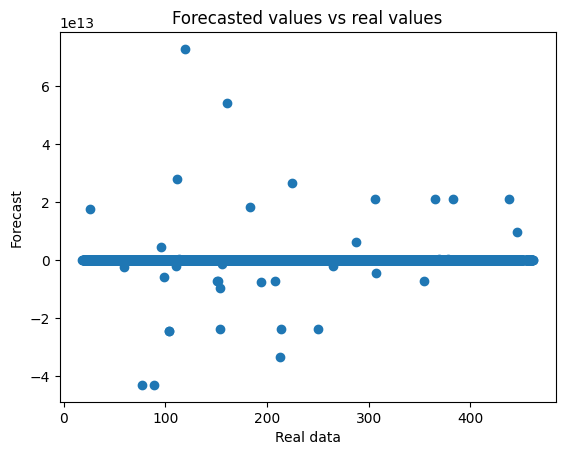

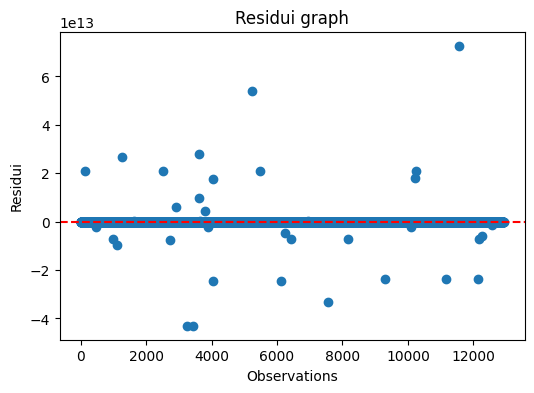

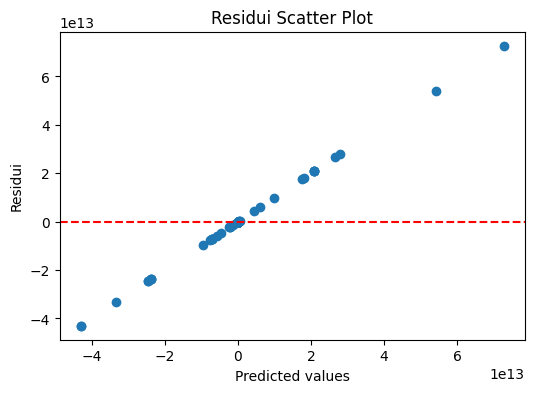

In [176]:
#vedere perchè non vengono bene

# Grafico di previsione rispetto ai dati reali
plt.scatter(y_val, y_pred_poly)
plt.xlabel("Real data")
plt.ylabel("Forecast")
plt.title("Forecasted values vs real values")
plt.show()

# Grafico dei residui
residuals = y_pred_poly - y_val
plt.figure(figsize=(6, 4))
plt.scatter(np.arange(len(residuals)), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Observations")
plt.ylabel("Residui")
plt.title("Residui graph")
plt.show()

# residui scatterplot

plt.figure(figsize=(6, 4))
plt.scatter(y_pred_poly, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residui")
plt.title("Residui Scatter Plot")
plt.show()

From the previous graph we can notice a clear patter, thus...provare a migliorare modello con un tuning e poi provare anche a fare robusto con statsmodels

Solving Overfitting Problem

Solving the overfitting problem starts with hyperparameter tuning. We should try different hyperparameters to find the optimum values where the model performs well on both training and testing data. This was a simple model. We have only one hyperparameter here which is the degree in the PolynomialFeatures method. 

__Grid Search for Hyperparameter Tuning__

Sklearn library provides us with functionality to define a grid of parameters and to pick the optimum one. Let us see how that can be used to decide on a proper degree for our prediction.

In [29]:
# check our accuracy for each degree, the lower the error the better!
number_degrees = [1,2] #3,4,5
poly_mse = []
for degree in number_degrees:

   poly_model = PolynomialFeatures(degree=degree)
  
   poly_x_train = poly_model.fit_transform(X_train)
   poly_x_val = poly_model.transform(X_val)
   poly_model.fit(poly_x_train, y_train)
  
   regression_model = LinearRegression()
   regression_model.fit(poly_x_train, y_train)
   y_pred = regression_model.predict(poly_x_val)
  
   poly_mse.append(mean_squared_error(y_val, y_pred, squared=False))
  
plt.scatter(number_degrees,poly_mse, color="green")
plt.plot(number_degrees,poly_mse, color="red") 

: 

: 

In [44]:

# Creazione del modello di regressione polinomiale con Ridge
poly_model_ridge = make_pipeline(PolynomialFeatures(), Ridge())

# Creazione del modello di regressione polinomiale con Lasso
poly_model_lasso = make_pipeline(PolynomialFeatures(), Lasso())

# Parametri da testare
param_grid_lasso = {
    'polynomialfeatures__degree': [1, 2],  # Gradi del polinomio
    'lasso__alpha': [0.01, 0.1, 1, 10]      # Parametri di regolarizzazione per Lasso
}    
param_grid_ridge = {
    'polynomialfeatures__degree': [1, 2],  # Gradi del polinomio
    'ridge__alpha': [0.01, 0.1, 1, 10]       # Parametri di regolarizzazione per Ridge
}

# Ricerca a griglia con cross-validation per Ridge
grid_search_ridge = GridSearchCV(poly_model_ridge, param_grid_ridge, cv=5)
grid_search_ridge.fit(X, y)

print("Miglior parametro per Ridge:", grid_search_ridge.best_params_)
print("Miglior punteggio di cross-validation per Ridge:", grid_search_ridge.best_score_)

# Ricerca a griglia con cross-validation per Lasso
grid_search_lasso = GridSearchCV(poly_model_lasso, param_grid_lasso, cv=5)
grid_search_lasso.fit(X, y)

print("Miglior parametro per Lasso:", grid_search_lasso.best_params_)
print("Miglior punteggio di cross-validation per Lasso:", grid_search_lasso.best_score_)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.35784e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.74462e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.54748e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.00274e-20): result may not be acc

Miglior parametro per Ridge: {'polynomialfeatures__degree': 1, 'ridge__alpha': 10}
Miglior punteggio di cross-validation per Ridge: 0.1462312512707186


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.227e+08, tolerance: 6.926e+04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.116e+08, tolerance: 6.566e+04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Bayes regression tanto non va

In [146]:
from sklearn.linear_model import BayesianRidge

# Creazione dell'istanza del modello
#bayes_model = BayesianRidge()
bayes_model = BayesianRidge(alpha_1=1e-6, alpha_2=1e-6)

# Addestramento del modello sui dati
bayes_model.fit(X_train, y_train)

# Predizione sui dati di test
y_pred_bayes = bayes_model.predict(X_val)

# Valutazione del modello con le metriche desiderate
# (ad esempio, RMSE, MAE, ecc.)

model_valid(bayes_model, X_train, X_val)

R^2 on train dataset 0.606609999870885
R^2 on validation dataset 0.6032736334513575
Adjusted R-squared: 0.6001797680021752
MAE: 47.88485727045599
MSE: 3787.0704055936153
RMSE: 61.539177810510395


Quantile regression

In [160]:
s = 'yy_train ~ '
for k in col_ind:
    s = s+ k+' + '

quantile = 0.5

#Add intercept to X_train
XZ_train = sm.add_constant(X_train)

#create the model
model = sm.QuantReg(y_train, XZ_train)
quantile_result = model.fit(q=quantile)

print(quantile_result.summary())

#validation
XZ_val = sm.add_constant(XX_val)
predictions = quantile_result.predict(XZ_val)
#print("Predictions on Validation Set:", predictions)

# Calcola le metriche di valutazione del modello (ad es. RMSE, MAE, ecc.)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])


                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.3998
Model:                       QuantReg   Bandwidth:                       7.802
Method:                 Least Squares   Sparsity:                        126.4
Date:                Thu, 17 Aug 2023   No. Observations:                38772
Time:                        19:11:30   Df Residuals:                    38681
                                        Df Model:                           90
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.9004      5.293     13.773      0.000      62.526      83.275
x1            42.7923      1.712     24.989      0.000      39.436      46.149
x2            -0.1346      0.007    -20.586      0.000      -0.147      -0.122
x3            -0.0039      0.011     -0.370      0.7

At this point try different kind of models, non linear one

KNN Regression

In [180]:
k = 5  #neighbors number
knn_model = KNeighborsRegressor(n_neighbors=k)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_val)
model_valid(knn_model, X_train, X_val, y_train, y_val)


R^2 on train dataset 0.8674043925791783
R^2 on validation dataset 0.7842686681969295
Adjusted R-squared: 0.7825862901901989
MAE: 31.6236304549675
MSE: 2059.328068709378
RMSE: 45.37982006034596


In [199]:
#param_grid_knn = {'n_neighbors': list(range(1,21)),'weights' : ['uniform','distance'],'metric' : ['minkowski','euclidean','manhattan']}
param_grid_knn = {'n_neighbors': [1, 3, 5, 7, 9],'weights' : ['uniform','distance'],'metric' : ['minkowski','euclidean','manhattan']} #tuning parameters

grid_search_knn = GridSearchCV(KNeighborsRegressor(), param_grid_knn, cv=5, scoring ='neg_mean_squared_error') 
grid_search_knn.fit(X_train, y_train)

knn_best_model = grid_search_knn.best_estimator_
best_k = grid_search_knn.best_params_['n_neighbors']

print("Best k:", best_k)

Best k: 7


In [200]:
model_valid(knn_best_model, X_train, X_val, y_train, y_val)

R^2 on train dataset 0.9715149021534362
R^2 on validation dataset 0.8259338050401772
Adjusted R-squared: 0.8245763520653677
MAE: 25.60212139727227
MSE: 1661.601020576002
RMSE: 40.76274059206522


**SVM**

Support Vector Machines (SVM) possono essere utilizzati anche per problemi di regressione, non solo per la classificazione. Nella regressione SVM, l'obiettivo è quello di trovare una funzione che si avvicini il più possibile ai dati di addestramento, mantenendo un certo margine. Questo può essere utile per affrontare problemi di regressione non lineare. La SVM per la regressione utilizza l'obiettivo di minimizzare l'errore rispetto a una soglia specificata (epsilon) e cercare di massimizzare il margine. I parametri C e kernel influenzano la complessità del modello e la flessibilità nell'adattamento ai dati.

In [27]:
#define model and parameters to tune
svr_param_grid = {
    'kernel':['poly', 'rbf', 'linear'], #kernel kind 
    'C':[10, 1.0, 0.1, 0.01, 0.001], # Parametro di regolarizzazione (più grande C, meno regolarizzazione)
    'epsilon': [0.01, 0.1, 0.2] # Tolleranza per la soglia dell'errore
}

#svm_regressor = SVR()
svr_model = SVR()

svr_grid = RandomizedSearchCV(estimator=svr_model, param_grid=svr_param_grid, n_jobs=-1, cv=3, scoring ='neg_mean_squared_error')
svr_grid.fit(X_train, y_train)

#summarize results
model_valid(svr_grid)

In [ ]:
#valuare grid_search

Tuttavia, tieni presente che le SVM per la regressione potrebbero non essere sempre la scelta migliore, soprattutto se il tuo dataset è molto grande. Altre tecniche come le regressioni lineari o alberi decisionali potrebbero essere più adatte in alcune situazioni.

**Random Forest Regression**

In [191]:
#base model 

rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_val)

#model evaluation results
print('Random Forest Regression evaluation metrics:')
model_valid(rf_reg, X_train, X_val, y_train, y_val)

print('Normalized RMSE ', round(np.sqrt(metrics.mean_squared_error(y_val, y_pred_rf)))/(max(y_val)-min(y_val)),2)
# RMSE/(max(DV)-min(DV))
#print('Max Value: ', max(y), '\nMin Value: ', min(y))


Random Forest Regression evaluation metrics:
R^2 on train dataset 0.9617630911116094
R^2 on validation dataset 0.8697933526831836
Adjusted R-squared: 0.868777937824595
MAE: 23.170473705101863
MSE: 1242.926566627937
RMSE: 35.25516368743644
Normalized RMSE  0.08


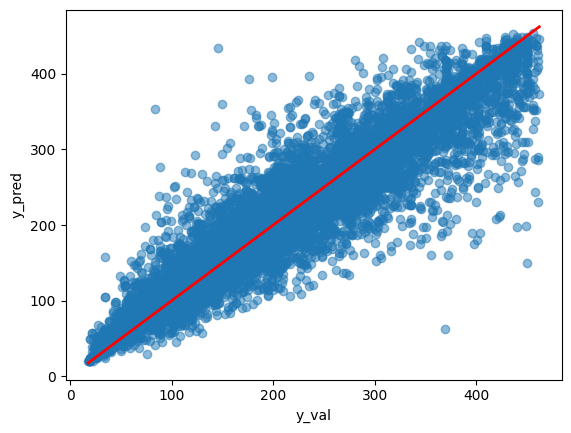

In [194]:
# Plot performance graph
plt.scatter(y_val, y_pred_rf, alpha = 0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linewidth=2)  #ma val o pred??
plt.xlabel("y_val")
plt.ylabel("y_pred")
plt.show()

In [184]:
#start tuning parameters for random forest
rfc_i = RandomForestRegressor()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 5, 10, 20]
min_samples_leaf = [1, 2, 5, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rcv = RandomizedSearchCV(rfc_i, random_grid, verbose=1, scoring='neg_mean_squared_error', n_jobs=-1)
rcv.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviou

RandomizedSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'n_estimators': [5, 115, 226, 336, 447,
                                                         557, 668, 778, 889,
                                                         1000]},
                   scoring='neg_mean_squared_error', verbose=1)

In [185]:
#verify if there is an improvement with respect to the base model
print(rcv.best_params_)
best_random = rcv.best_estimator_
model_valid(best_random, X_train, X_val)

R^2 on train dataset 0.9239061919829001
R^2 on validation dataset 0.8505180151105209
Adjusted R-squared: 0.849352281780649
MAE: 26.724784124514922
MSE: 1426.9250770226506
RMSE: 37.77466183862737


In [186]:
print(rcv.best_params_)

{'n_estimators': 557, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}


Since we have better results after tuning paramteres, according to the parameters identified by random search grid we can...implement a gridsearch more narrow down etc

In [196]:
# Create the parameter grid based on the results of random search 
param_grid_rf = {
    'bootstrap': [False],
    'max_depth': [50, 60, 70, 80, 90],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [3, 5, 8],
    'n_estimators': [500, 550, 600, 650, 700]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid_rf, 
                          cv = 3, n_jobs = -1, verbose = 1) #---> non avevo aggiunto scoring ='neg_mean_squared_error'

In [197]:
# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False],
                         'max_depth': [50, 60, 70, 80, 90],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [3, 5, 8],
                         'n_estimators': [500, 550, 600, 650, 700]},
             verbose=1)

In [198]:
#best model
grid_search_rf.best_params_
best_grid_rf = grid_search_rf.best_estimator_
model_valid(best_grid_rf, X_train, X_val)

R^2 on train dataset 0.9563246601204738
R^2 on validation dataset 0.8658802012670308
Adjusted R-squared: 0.8648342697476284
MAE: 24.162054288758462
MSE: 1280.2807259938536
RMSE: 35.781010689943535


In [ ]:
from tqdm.notebook import tqdm

var_list = feat.columns
loco_res = {}
# Numero di bootstrap samples
n_bootstrap_samples = 20 #era 100, magari fare una prova con altri valori 50, 10 etc
# Livello di significatività desiderato
alpha = 0.05
#var_imp --> list of var, take first 10

for feature in var_list:
    loco_scores = []
   
    for _ in tqdm(range(n_bootstrap_samples)): 
        X_train_loco, X_test_loco, y_train_loco, y_test_loco = train_test_split(feat,price, test_size=0.2) #Randomly split the training data into two, non overlapping, parts
        
        reg = RandomForestRegressor() #Run any algorithm you like to compute an estimate fn1 (·) on first part Dn1 .
        reg.fit(X_train_loco, y_train_loco)
        y_pred_loco = reg.predict(X_test_loco)
        baseline_metric = r2_score(y_test_loco, y_pred_loco)
        
        # Temporarily remove the current feature
        X_train_loco = X_train_loco.drop(feature, axis=1)
        X_test_loco = X_test_loco.drop(feature, axis=1)
        
        # Retrain the model on the modified dataset
        reg_temp = RandomForestRegressor()
        reg_temp.fit(X_train_loco, y_train_loco)
        # Make predictions on the modified dataset
        y_pred_temp = reg_temp.predict(X_test_loco)
        # Compute the r2_score and LOCO score
        metric_temp = r2_score(y_test_loco, y_pred_temp)
        loco_score = metric_temp - baseline_metric #def (l^-j - l) for each j in first_10  #devo mettere median qui?
        loco_scores.append(loco_score)
        
        
    loco_res[feature] = loco_scores #100 theta_j for each j 

In [ ]:
# Lista per memorizzare gli intervalli di confidenza delle mediane
#n_bootstrap_samples = 100
#alpha = 0.05
confidence_intervals = []
store = []
for elem in var_list:

    # Campione di loco scores
    bootstrap_loco = loco_res[elem]

    # Calcolo dell'intervallo di confidenza corretto di Bonferroni
    sorted_loco = np.sort(bootstrap_loco)
    store.append(np.median(sorted_loco))
    
    lower_bound = sorted_loco[int(10 * alpha / 2)] #credo che al posto di 10 vada in numero di variabili che stiamo analizzando
    upper_bound = sorted_loco[int(10 * (1 - alpha / 2))]# idem di quello sopra
    
    # Aggiunta dell'intervallo di confidenza alla lista
    confidence_intervals.append((round(lower_bound,4), round(upper_bound,4)))

# Stampa degli intervalli di confidenza corretti di Bonferroni per ciascuna variabile   #ritornare il nome della variabile
for i, interval in enumerate(confidence_intervals):
    print('-'*90)
    print(f'Variabile', var_list[i],': '+'confidence interval =', interval, ', LOCO score', round(store[i],4)) 
    #print(f"Variabile {i+1}: confidence interval = {interval}")
print('-'*90)